In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
#setPltLinewidth(0)
from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import json
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import random   
#adata=cs.hf.read("/home/zhengtuo/songtao/carlin4.18_all.h5ad")
#adata=cs.hf.read("/home/zhengtuo/songtao/4.16_ourfate_carlin.h5ad")
#adata=cs.hf.read("/home/zhengtuo/songtao/carlin_filter_all.h5ad")
#adata.obs['index']=range(adata.shape[0])
#adata3=cs.hf.read("/home/zhengtuo/songtao/HSC_Mk_Neu_carlin.h5ad")

In [2]:
#adata_orig1=cs.hf.read("/home/zhengtuo/GSE146972_Bowling/all_bowling.log1p.h5ad")
adata_geneex=cs.hf.read("/home/zhengtuo/songtao/carlin_filter_all2.h5ad")


In [249]:
#adata_geneex=cs.hf.read("/home/songtaojiang/deng/yifenghua_41980.h5ad")
adata_geneex = adata_geneex[:, np.sum(adata_geneex.X, axis=0) > 0]

data_df = pd.DataFrame(adata_geneex.X.toarray(), index=adata_geneex.obs_names, columns=adata_geneex.var_names)
print('Working on {} cells and {} genes'.format(*data_df.shape))

Working on 32748 cells and 15772 genes


In [ ]:
##Contruct Triplet
import scanpy as sc
import scanpy as sc
import json
from collections import Counter
# bowling_adata.write_h5ad("/Users/snow/Desktop/all_bowling.log1p.h5ad")
#bowling_adata= cs.hf.read("/home/zhengtuo/GSE146972_Bowling/all_bowling.log1p.h5ad")
bowling_adata=cs.hf.read("/home/zhengtuo/songtao/carlin_filter_all2.h5ad")
bowling_adata.obs['index']=range(bowling_adata.shape[0])
#bowling_adata.X=bowling_adata.X.astype('float32')
#bowling_adata.obs.index=bowling_adata.obs.index.str.split('_').str.get(0)
# def change_annotation(annotation):
#     if annotation == 'HSC' or annotation == 'MPP':
#         return 'HSC'
# #     elif annotation == 'Mo' or annotation == 'Neu':
# #         return 'My'
# #     elif annotation == 'Ery' or annotation == 'Mk':
# #         return 'Ery'
#     else:
#         return annotation 
# bowling_adata.obs['reannotation'] = bowling_adata.obs['reannotation'].apply(change_annotation)
def recursive_node(G,adata,cells,node):
    if len(node) == 0:
        return 
    else:
        for children in node:
            G.add_edge(children['parent'], children['name'])
            if children['name'].startswith("N"):
                for j in children['cellIDs'].split(","):
                    if j+ '-1' in adata.obs.index:
                        G.add_edge(children['name'], j + '-1')
                        cells.append(j + '-1')
            else:
                recursive_node(G,adata,cells,children['children'])
                
def recursive_childrens(G,adata,cells,clades,events,node):
    if len(node) == 0:
        return 
    else:
        for children in node:
            G.add_edge(children['parent'], children['name'])
            if children['name'].startswith("N"):
                for j in children['cellIDs'].split(","):
                    if j+ '-1' in adata.obs.index:
                        G.add_edge(children['name'], j + '-1')
                        cells.append(j+ '-1')
            else:
                tmp_cells = []
                recursive_node(G, adata, tmp_cells, children['children'])
                d = dict(Counter((adata[tmp_cells].obs['reannotation'])))
                clades[children['name']] = d
                clades[children['name']]['cellIDs'] = tmp_cells
                events[children['name']] = children['event']
                recursive_childrens(G,adata,cells,clades,events,children['children'])
        
def bowling_relation(G,adata):
    MAX_DISTANCE=5
    cell2depth = {}
    node2depth = {}
    for i in list(filter(lambda x: not x.startswith("N") and not x.endswith("-1"), G.nodes())):
        node2depth[i] = len(nx.shortest_path(G, source='null', target=i))

    relations = []
    all_cell_ids = list(adata.obs.index)
    all_cell_ids_index = dict(zip(all_cell_ids, range(len(all_cell_ids))))
    checked_edges = set()
    checked_nodes = set()
    clade_node_cell = {}
    node2clade = {}
    
    # For all node in the lineage tree graph
    for node in list(filter(lambda x: not x.startswith("N") and not x.endswith("-1"), G.nodes())):
        clade_node_cell[node] = {}
        node_cells = []
        allns = list(map(lambda x: x[0], filter(lambda x: not x[0].startswith("N") and not x[0].endswith("-1"), nx.single_source_shortest_path_length(G, node, cutoff=1).items())))

        for n,d in list(filter(
            lambda x: x[0].startswith("N") and not x[0].endswith("-1"), 
            nx.single_source_shortest_path_length(G, node, cutoff=1).items())
        ):
            clade_node_cell[node][n] = list(map(lambda x: x[0], filter(lambda x: x[1] == 1, nx.single_source_shortest_path_length(G, n, cutoff=1).items())))
            node2clade[n] = node
            for c in clade_node_cell[node][n]:
                cell2depth[c] = node2depth[node]
            node_cells.append(clade_node_cell[node][n])
            for i in range(len(node_cells[-1])):
                for j in range(len(node_cells[-1])):
                    if i == j:
                        continue
                    if node_cells[-1][i] in all_cell_ids_index.keys() and node_cells[-1][j] in all_cell_ids_index.keys():
                        relations.append((
                            node, 
                            n, 
                            node_cells[-1][i], 
                            all_cell_ids_index[ node_cells[-1][i]],
                            node, 
                            n,
                            node_cells[-1][j], 
                            all_cell_ids_index[node_cells[-1][j]],
                            0)
                        )
    for node in list(filter(lambda x: not x.startswith("N") and not x.endswith("-1"), G.nodes())):
        edge_distance = {}
        for n,d in list(filter(
            lambda x: x[0].startswith("N") and not x[0].endswith("-1"), 
            nx.single_source_shortest_path_length(G, node, cutoff=MAX_DISTANCE).items())
        ):
            if d not in edge_distance.keys():
                edge_distance[d] = [n]
            else:
                edge_distance[d].append(n)
        if 1 in edge_distance.keys():
            for n1 in edge_distance[1]:
                for k in range(2, MAX_DISTANCE+1):
                    if k in edge_distance.keys():
                        for n2 in edge_distance[k]:
                            for cell_1 in clade_node_cell[node][n1]:
                                for cell_2 in clade_node_cell[node2clade[n2]][n2]:
                                    if cell_1 in all_cell_ids_index.keys() and cell_2 in all_cell_ids_index.keys():
                                        relations.append((
                                            node, 
                                            n1, 
                                            cell_1, 
                                            all_cell_ids_index[cell_1],
                                            node2clade[n2],
                                            n2,
                                            cell_2,
                                            all_cell_ids_index[cell_2],
                                            k-1)
                                        )
    return relations

bowling_adata_dict = {}
for i in np.unique(bowling_adata.obs['sample_name']):
    bowling_adata_dict[i] = bowling_adata[bowling_adata.obs['sample_name'] == i]

import sys
import networkx as nx
all_relations = []
for sample_name, tree_name in zip(
    ['GSM4413333', 'GSM4413334', 'GSM4413335', 'GSM4413336', 'GSM4413337', 'GSM4413338', 'GSM4413339'],
    [
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO817_SC_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO837_SC_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO892_SC_1_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO892_SC_2_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO897_SC_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_FO898_SC_output_hmid.json',
        '/home/zhengtuo/songtao/TreeUtil/5FU_SB133_SC_output_hmid.json',
    ]):
        tree = json.load(open(tree_name))

        cells = []
        G = nx.DiGraph()
        clade = {}
        events = {}
        bowling_adata_dict[sample_name].obs.index = list(map(lambda x: x.split("_")[0], bowling_adata_dict[sample_name].obs.index))
        recursive_childrens(G, bowling_adata_dict[sample_name], cells, clade, events, tree)
        data = pd.DataFrame({k:{i:j for i,j in v.items() if i != 'cellIDs'} for k,v in clade.items()}).T.fillna(0)
        data_norm = (data.T / data.sum(1)).T
        bowling_adata_dict[sample_name].obs['preference_HSC'] = None

        for i, j in enumerate(torch.tensor(data_norm.loc[:, ['Ery', 'Mk', 'Mo', 'Neu']].to_numpy()).topk(2)[1].squeeze().numpy()):

            max_index, second_max_index = j
            max_value, second_max_value = data_norm.loc[data_norm.index[i], ['Ery', 'Mk', 'Mo', 'Neu']].iloc[max_index], data_norm.loc[data_norm.index[i], ['Ery', 'Mk', 'Mo', 'Neu']].iloc[second_max_index]
            if max_value > 0:
                if max_index == 1 or max_index == 0:  # 最多的是 Mk
                    if max_value > second_max_value+0.1:
                        bowling_adata_dict[sample_name].obs.loc[
                            clade[data_norm.index[i]]['cellIDs'],
                            'preference_HSC'
                        ] = ['Ery', 'Mk', 'Mo', 'Neu'][max_index]
                else:
                    if max_value > second_max_value+0.1:
                        bowling_adata_dict[sample_name].obs.loc[
                            clade[data_norm.index[i]]['cellIDs'],
                            'preference_HSC'
                        ] = ['Ery', 'Mk', 'Mo', 'Neu'][max_index]



            
        relations = pd.DataFrame(bowling_relation(G, bowling_adata_dict[sample_name]), columns=['from_clade','from_node', 'from_cell','from_index',
                                            'to_clade','to_node', 'to_cell','to_index','distance'])
        relations['from_cell'] = list(map(lambda x: x + '_' + sample_name, relations['from_cell']))
        relations['to_cell'] = list(map(lambda x: x + '_' + sample_name, relations['to_cell']))
        all_relations.append(relations)


all_relations = pd.concat(all_relations, ignore_index=True)
bowling_cell_index = dict(zip(bowling_adata.obs.index, list(range(len(bowling_adata)))))
all_relations['from_index'] = list(map(bowling_cell_index.get, all_relations['from_cell']))
all_relations['to_index'] = list(map(bowling_cell_index.get, all_relations['to_cell']))

bowling_cell_type = dict(zip(bowling_adata.obs.index, bowling_adata.obs['reannotation'] ))
all_relations['from_cell_type'] = list(map(bowling_cell_type.get, all_relations['from_cell']))
all_relations['to_cell_type'] = list(map(bowling_cell_type.get, all_relations['to_cell']))

bowling_adata_ = sc.concat(bowling_adata_dict.values())
bowling_adata_=bowling_adata_[~bowling_adata_.obs['sample_name'].isin(['GSM4413334','GSM4413333'])]

# fig,ax=createFig()
# fig.set_size_inches(3,3)
# sc.pl.umap(bowling_adata_, color='preference_HSC', s=5, ax=ax)
# sc.pl.umap(bowling_adata_[(bowling_adata_.obs['preference_HSC'].isin(['My','Ery']))], color='preference_HSC', s=5, ax=ax)



In [224]:
bowling_adata= cs.hf.read("/home/zhengtuo/GSE146972_Bowling/all_bowling.log1p.h5ad")
with open("/home/zhengtuo/songtao/filter_genes.txt", "r") as f:
    gene_list = [line.strip() for line in f]

# 从adata.var中筛选基因名在gene_list中的基因
gene_mask = [gene in gene_list for gene in bowling_adata.var_names]
bowling_adata = bowling_adata[:, gene_mask]



In [227]:
bowling_adata

View of AnnData object with n_obs × n_vars = 32748 × 20864
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP'
    uns: 'preference_HSC_colors', 'preference_MPP_colors'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [16]:
sc.write('/home/zhengtuo/songtao/carlin_filter_all.h5ad',adata_orig)

In [252]:
adata=bowling_adata_.copy()
# adata = adata[((adata.obs['preference_HSC'].isin(['Mo', 'Ery','Neu', 'Mk'])) | (pd.isna(adata.obs['preference_HSC']))) & (adata.obs['reannotation'].isin(['Mo', 'HSC','Ery', 'Neu', 'Mk']))]
# adata


In [88]:
adata

AnnData object with n_obs × n_vars = 25499 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [139]:
#adata=bowling_adata_.copy()
adata=bowling_adata_[(bowling_adata_.obs['preference_HSC'].isin(['Mo','Ery','Neu','Mk']))&(bowling_adata_.obs['reannotation'].isin(['Mo','HSC','Neu','Mk']))]
adata


View of AnnData object with n_obs × n_vars = 1602 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [138]:
#dic1={'HSC':'HSC','MPP':'HSC','Mo':'My','Neu':'My','Mk':'Ery','Ery':'Ery'}
dic1={'Mo':'My','Neu':'My','Mk':'Ery','HSC':'HSC','Ery':'Ery'}

adata.obs['preference_HSC']=adata.obs['preference_HSC'].map(dic1)
adata.obs['reannotation']=adata.obs['reannotation'].map(dic1)
adata
# adata=adata[adata.obs['reannotation'].isin(['HSC','My','Ery'])]
# dic_class={}
# for i in range(adata.shape[0]):
#     dic_class[adata.obs['index'][i]]=adata.obs['reannotation'][i]

# adata.obs

/tmp/ipykernel_151882/3133665637.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['preference_HSC']=adata.obs['preference_HSC'].map(dic1)


AnnData object with n_obs × n_vars = 382 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [6]:
dic_class={}
for i in range(adata.shape[0]):
    dic_class[adata.obs['index'][i]]=adata.obs['reannotation'][i]

In [931]:
all_relations[all_relations['from_cell_type']=='HSC']['from_index'].unique().shape
bowling_adata[bowling_adata.obs['reannotation']=='HSC']


View of AnnData object with n_obs × n_vars = 11182 × 28692
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP'
    uns: 'preference_HSC_colors', 'preference_MPP_colors'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

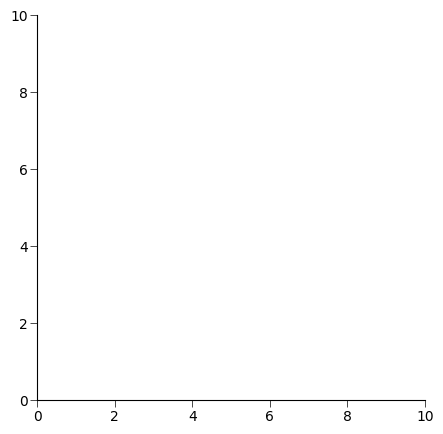

In [6]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1


In [1075]:
# df=all_relations
# df=df[(df['from_index'].isin(adata.obs['index']))&(df['to_index'].isin(adata.obs['index']))]
# # adata2=adata[adata.obs['reannotation']=='HSC'].obs['index'].unique()
# # df=df[df['from_index'].isin(adata2)]
# # df['from_cell_type'] = df['from_index'].map(dic_class)
# # df['to_cell_type'] = df['to_index'].map(dic_class)
# df['from_cell_type'] = df['from_cell_type'].map(dic1)
# df['to_cell_type'] = df['to_cell_type'].map(dic1)
# df=df[df['from_cell_type']=='HSC']
# df=df[df['to_cell_type'].isin(['My','Ery'])]
# indf=list(df['from_index'].unique())+list(df['to_index'].unique())
# adata=adata[adata.obs['index'].isin(indf)]
# adata.obs


In [55]:
adata[adata.obs['reannotation'] == 'HSC'].obs['preference_HSC'].value_counts()

Mk     387
Neu    224
Ery    143
Mo      82
Name: preference_HSC, dtype: int64

In [344]:
#bowling_adata.obs['index']=range(bowling_adata.shape[0])
# adata=bowling_adata_
adata[adata.obs['reannotation'] == 'HSC'].obs['preference_HSC'].value_counts()

Neu    235
Mo     147
Name: preference_HSC, dtype: int64

In [25]:
counts_by_sample = adata.obs.groupby('sample_name')['preference_HSC'].apply(lambda x: x.value_counts()).unstack(fill_value=0)
print(counts_by_sample)


In [17]:
df = all_relations[all_relations['from_cell_type'].isin(['HSC'])]
df = df[df['to_cell_type'].isin([ 'Neu','Mo'])]

# 统计每个from_index对应的to_cell_type里哪个种类的属性值最多
grouped = df.groupby(['from_index', 'to_cell_type']).size().reset_index(name='counts')

# 定义一个自定义函数，该函数返回满足条件的to_cell_type
def get_max_fate(group, threshold=5):
    group = group.sort_values(by='counts', ascending=False).reset_index(drop=True)
    if len(group) > 1:
        if group.loc[0, 'to_cell_type'] in ['Neu']:#3 1.5 2 1.2
            if group.loc[0, 'counts'] > 2* group.loc[1, 'counts']:
                return group.loc[0, 'to_cell_type']
            else:
                return None
        else:
            if group.loc[0, 'counts'] > 1.2 * group.loc[1, 'counts']:
                return group.loc[0, 'to_cell_type']
            else:
                return None
    else:
        return group.loc[0, 'to_cell_type']


# 对每个from_index应用自定义函数
fate_df = grouped.groupby('from_index').apply(get_max_fate).reset_index(name='to_cell_type')

# 将结果存储到字典dic_fate中
dic_fate = fate_df.set_index('from_index')['to_cell_type'].to_dict()
adata=bowling_adata_
adata.obs['preference_HSC'] = adata.obs['index'].map(dic_fate)
#adata=adata[adata.obs['sample_name']=='GSM4413339']
#adata= adata[~adata.obs['preference_HSC'].isin(['Ba','Mo'])]
replace_rules = {'Mo': 'Mo', 'Neu': 'Neu', 'Ery': 'Ery', 'Mk': 'Ery'}

adata.obs['preference_HSC'] = adata.obs['preference_HSC'].replace(replace_rules)

#adata = adata[((adata.obs['reannotation'] == 'HSC') & pd.notnull(adata.obs['preference_HSC'])) | (adata.obs['reannotation'] != 'HSC')]
adata

AnnData object with n_obs × n_vars = 25499 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [7]:
# import pandas as pd
# import scanpy as sc

mm10_genes = pd.read_csv("/home/zhengtuo/songtao/mm10_PCG.txt", header=None, names=["gene"])

adata_filter = adata[:, adata.var.index.isin(mm10_genes["gene"])]
sc.pp.highly_variable_genes(adata_filter)
adata_filter=adata_filter[:, adata_filter.var.highly_variable]
# # 输出筛选后的adata对象
print(adata_filter)


/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


View of AnnData object with n_obs × n_vars = 25499 × 1704
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'


/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
sc.write('/home/zhengtuo/songtao/carlin_1704.h5ad',adata)

In [18]:
df = all_relations[all_relations['from_cell_type'].isin(['HSC'])]
df = df[df['to_cell_type'].isin([ 'Neu','Mo','Mk','Ery'])]

# 统计每个from_index对应的to_cell_type里哪个种类的属性值最多
grouped = df.groupby(['from_index', 'to_cell_type']).size().reset_index(name='counts')

# 定义一个自定义函数，该函数返回满足条件的to_cell_type
def get_max_fate(group, threshold=5):
    group = group.sort_values(by='counts', ascending=False).reset_index(drop=True)
    if len(group) > 1:
        if group.loc[0, 'to_cell_type'] in ['Neu']:#3 1.5
            if group.loc[0, 'counts'] > 2 * group.loc[1, 'counts']:
                return group.loc[0, 'to_cell_type']
            else:
                return None
        else:
            if group.loc[0, 'counts'] > 1.2 * group.loc[1, 'counts']:
                return group.loc[0, 'to_cell_type']
            else:
                return None
    else:
        return group.loc[0, 'to_cell_type']


# 对每个from_index应用自定义函数
fate_df = grouped.groupby('from_index').apply(get_max_fate).reset_index(name='to_cell_type')

# 将结果存储到字典dic_fate中
dic_fate = fate_df.set_index('from_index')['to_cell_type'].to_dict()

In [19]:
# adata=bowling_adata_
# adata.obs['preference_HSC'] = adata.obs['index'].map(dic_fate)
# #adata=adata[adata.obs['sample_name']=='GSM4413339']
# #adata= adata[~adata.obs['preference_HSC'].isin(['Ba','Mo'])]
# replace_rules = {'Mo': 'Mo', 'Neu': 'Neu', 'Ery': 'Ery', 'Mk': 'Ery'}

# adata.obs['preference_HSC'] = adata.obs['preference_HSC'].replace(replace_rules)

# adata = adata[((adata.obs['reannotation'] == 'HSC') & pd.notnull(adata.obs['preference_HSC'])) | (adata.obs['reannotation'] != 'HSC')]


In [23]:
adata[adata.obs['reannotation'] == 'HSC'].obs['preference_HSC'].value_counts()

Neu    235
Mo     147
Name: preference_HSC, dtype: int64

In [21]:
df=df[(df['from_index'].isin(adata.obs['index']))&(df['to_index'].isin(adata.obs['index']))]
df

from_clade from_node                      from_cell  from_index  \
242357        368      N834  GAAATGAAGCTGGAGT-1_GSM4413335       10080   
242367        368      N825  TCCATCGCACACCTGG-1_GSM4413335       12058   
242368        368      N825  TCCATCGCACACCTGG-1_GSM4413335       12058   
242369        368      N825  TCCATCGCACACCTGG-1_GSM4413335       12058   
242381        368      N845  TTAGGGTCACGGTGAA-1_GSM4413335       12837   
...           ...       ...                            ...         ...   
843481        330      N328  AGGAATAGTTGAAGTA-1_GSM4413339       28680   
843494        330      N327  CTTCGGTAGTGCCGAA-1_GSM4413339       30137   
843496        330      N327  TAAGTCGGTGGATCGA-1_GSM4413339       31396   
843498        330      N327  TCCTTTCAGCAATAGT-1_GSM4413339       31859   
843506        324      N324  CTGTGGGGTCGATTTG-1_GSM4413339       30106   

       to_clade to_node                        to_cell  to_index  distance  \
242357      368    N834  CACTTCGGTGCACGCT-1_GSM4413335      8845         0   
242367      368    N825  TCATTACAGCAGATAT-1_GSM4413335     12009         0   
242368      368    N825  AGGGCTCTCGTAGTGT-1_GSM4413335      8166         0   
242369      368    N825  CTCACTGAGGCGCTTC-1_GSM4413335      9730         0   
242381      368    N845  TCATCATCAATTCTTC-1_GSM4413335     11965         0   
...         ...     ...                            ...       ...       ...   
843481      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843494      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843496      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843498      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843506      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         1   

       from_cell_type to_cell_type  
242357            HSC          Ery  
242367            HSC          Neu  
242368            HSC           Mk  
242369            HSC           Mk  
242381            HSC           Mk  
...               ...          ...  
843481            HSC           Mo  
843494            HSC           Mo  
843496            HSC           Mo  
843498            HSC           Mo  
843506            HSC           Mo  

[84037 rows x 11 columns]

In [22]:
indf=list(df['from_index'].unique())+list(df['to_index'].unique())
adata=adata[adata.obs['index'].isin(indf)]
adata

View of AnnData object with n_obs × n_vars = 3207 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhengtuo/miniconda3/envs/jst/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No

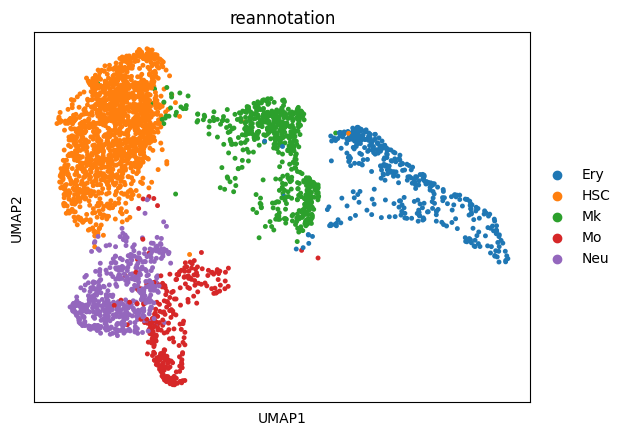

In [24]:
sc.pl.umap(adata,color="reannotation",s=50)


In [350]:
sc.write('/home/zhengtuo/songtao/carlin_mo_no2.h5ad',adata)

In [26]:
import pandas as pd

def calculate_fate(group):
    my_count = group.value_counts().get('My', 0)
    ery_count = group.value_counts().get('Ery', 0)
#     print(my_count)
#     print(ery_count)
    if ery_count - my_count >= 1:
        return 'Ery'
    elif my_count - ery_count >= 1:
        return 'My'
    else:
        return None

# 读取数据
# df = pd.read_csv('/home/zhengtuo/GSE146972_Bowling/all_bowling_relations.csv')
df = all_relations

# 过滤数据
adata2 = adata[adata.obs['reannotation'] == 'HSC'].obs['index'].unique()
df = df[(df['from_index'].isin(adata.obs['index'])) & (df['to_index'].isin(adata.obs['index'])) & (df['from_index'].isin(adata2))]

# 只保留 'My' 和 'Ery' 的行
df = df[df['to_cell_type'].isin(['Ery', 'My'])]

# 计算命运
fates = df.groupby('from_index')['to_cell_type'].apply(calculate_fate)

# 将结果转换为dataframe
fates_df = fates.reset_index().rename(columns={'to_cell_type': 'fate'})

# 将结果合并到原始数据中
df = df.merge(fates_df, on='from_index', how='left')


In [3353]:
#adata=cs.hf.read("/home/zhengtuo/songtao/4.16_ourfate_carlin.h5ad")
indf=list(df['from_index'].unique())+list(df['to_index'].unique())
adata=adata[adata.obs['index'].isin(indf)]
adata=adata[adata.obs['reannotation'].isin(['My','Ery','HSC'])]
# 将fates Series转换为DataFrame
fates_df = fates.reset_index().rename(columns={'from_index': 'index', 'to_cell_type': 'fate'})

# 将adata的obs属性转换为DataFrame
adata_obs_df = adata.obs.reset_index()

# 将fates_df与adata_obs_df合并
merged_adata_obs_df = adata_obs_df.merge(fates_df, on='index', how='left')

# 将合并后的DataFrame设置回adata的obs属性
adata.obs = merged_adata_obs_df.set_index('index')


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [4144, 4157, 4165, 4172, 4174]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [2113]:
adata2=adata[adata.obs['reannotation']=='HSC']
adata2.obs['fate']=adata2.obs['preference_HSC']
counts_by_sample = adata2.obs.groupby('sample_name')['fate'].apply(lambda x: x.value_counts()).unstack(fill_value=0)
print(counts_by_sample)


             Mo  Neu
sample_name         
GSM4413335   27   53
GSM4413336   16   22
GSM4413337   68   49
GSM4413338   10   24
GSM4413339   77   87


/tmp/ipykernel_81604/2395336883.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['fate']=adata2.obs['preference_HSC']


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


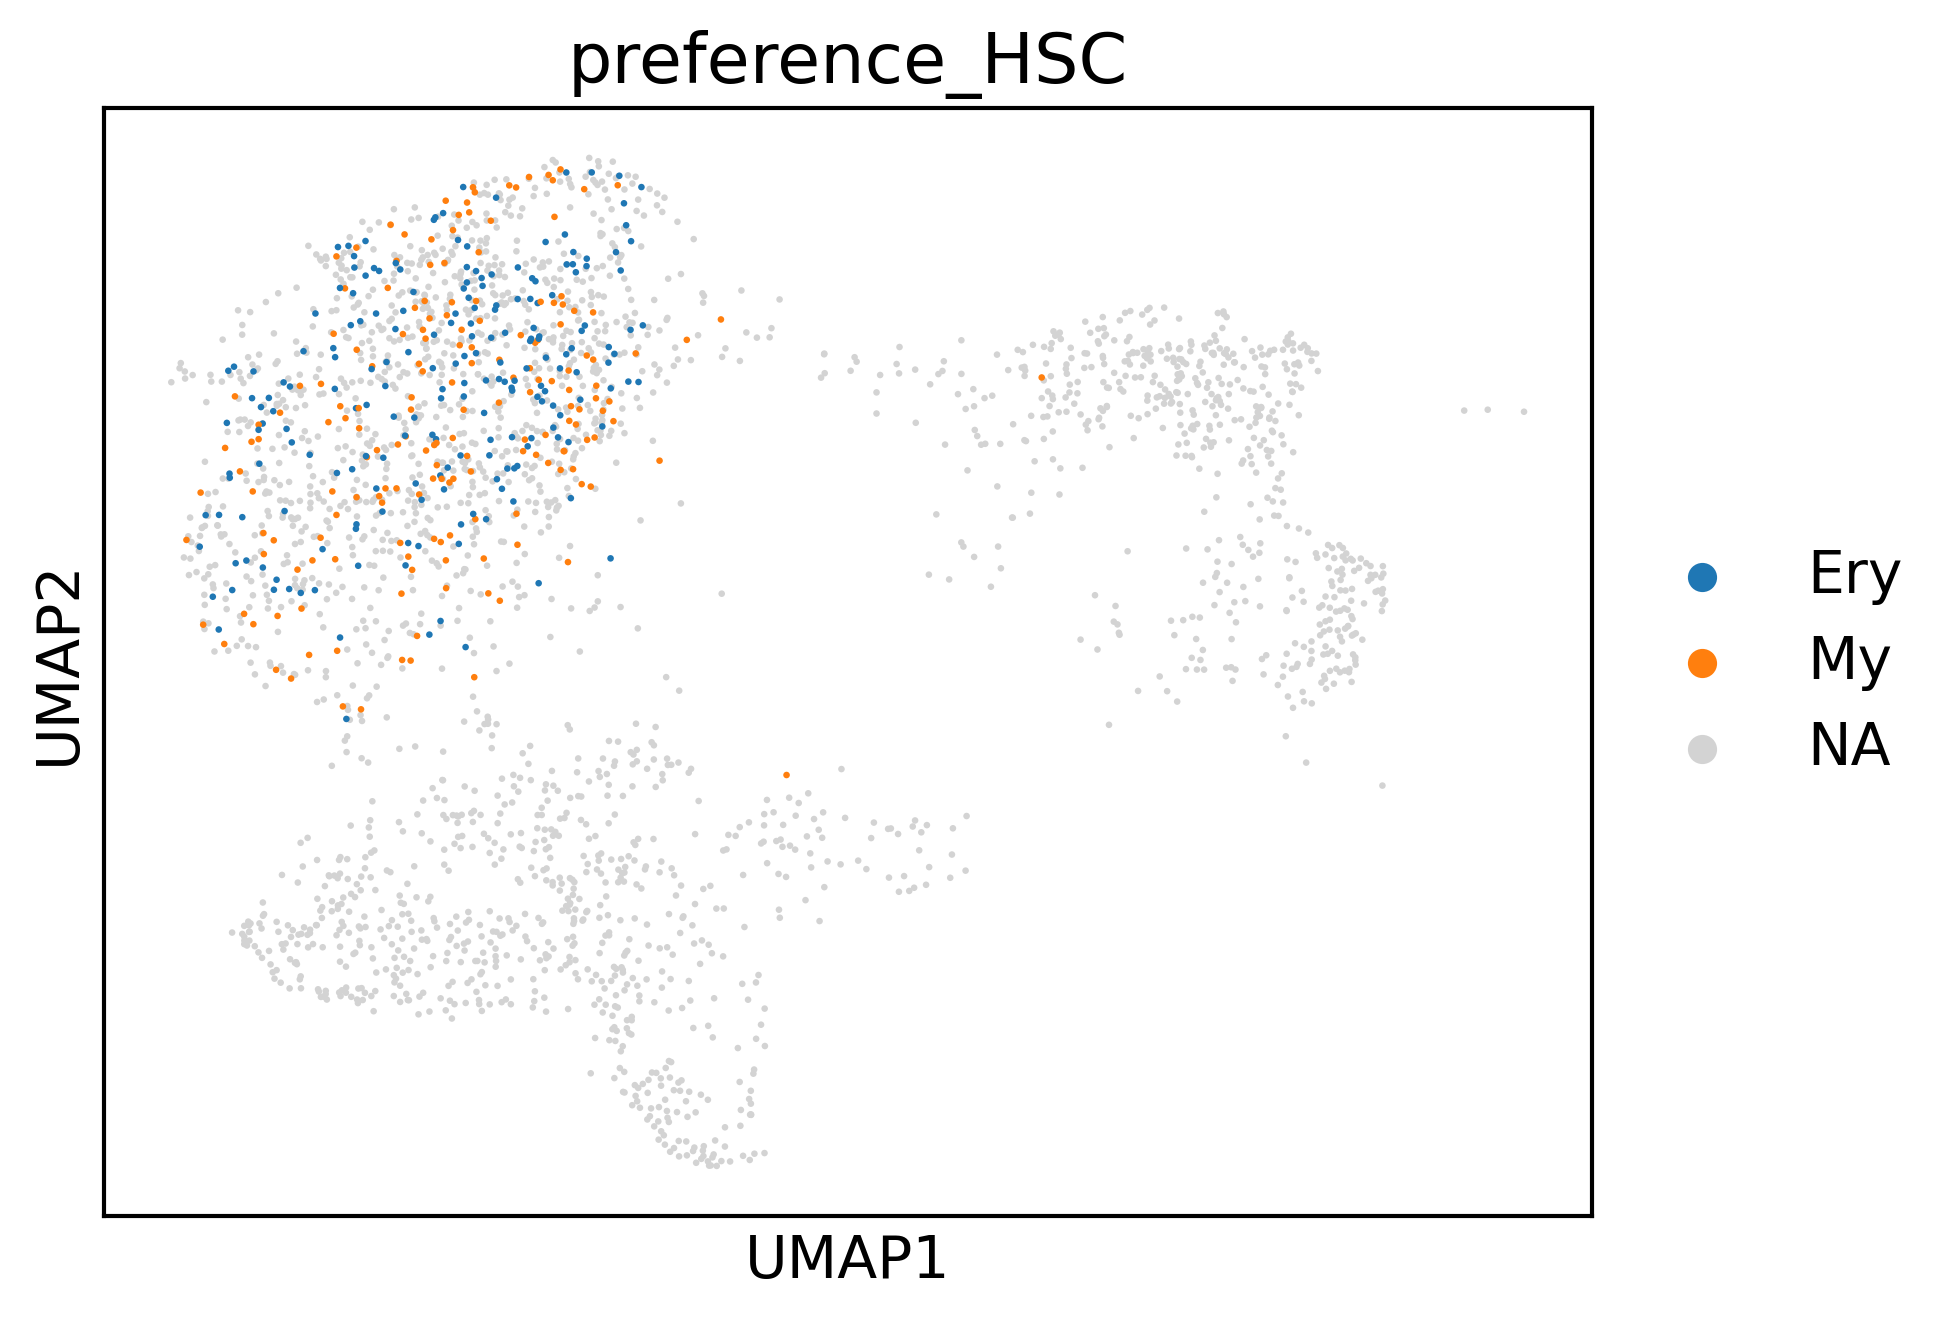

In [1670]:
sc.pl.umap(adata,color="preference_HSC",s=10)


In [170]:
df = all_relations
df=df[df['from_index'].isin(adata.obs['index'])]
df = df[df['to_cell_type'].isin(['Neu','Mo','Mk'])]
df = df[df['from_cell_type'].isin(['HSC'])]
df

from_clade from_node                      from_cell  from_index  \
242587        327      N819  CCAAGCGTCACCTCGT-1_GSM4413335        9086   
242589        327      N819  CCAAGCGTCACCTCGT-1_GSM4413335        9086   
242590        327      N819  CCAAGCGTCACCTCGT-1_GSM4413335        9086   
242601        327      N819  TAGGAGGCAAGTGATA-1_GSM4413335       11748   
242603        327      N819  TAGGAGGCAAGTGATA-1_GSM4413335       11748   
...           ...       ...                            ...         ...   
843456        330      N327  TAAGTCGGTGGATCGA-1_GSM4413339       31396   
843458        330      N327  CTTCGGTAGTGCCGAA-1_GSM4413339       30137   
843494        330      N328  AGGAATAGTTGAAGTA-1_GSM4413339       28680   
843498        330      N328  CTCAAGACATCAGTGT-1_GSM4413339       29934   
843506        324      N324  CTGTGGGGTCGATTTG-1_GSM4413339       30106   

       to_clade to_node                        to_cell  to_index  distance  \
242587      327    N819  TCACTATTCTACGCAA-1_GSM4413335     11915         0   
242589      327    N819  AAAGGATGTGGGTATG-1_GSM4413335      7279         0   
242590      327    N819  AGCGCTGAGGCGAACT-1_GSM4413335      8033         0   
242601      327    N819  TCACTATTCTACGCAA-1_GSM4413335     11915         0   
242603      327    N819  AAAGGATGTGGGTATG-1_GSM4413335      7279         0   
...         ...     ...                            ...       ...       ...   
843456      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843458      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843494      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843498      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         2   
843506      326    N326  CAACAACAGCTCCATA-1_GSM4413339     29130         1   

       from_cell_type to_cell_type  
242587            HSC           Mk  
242589            HSC          Neu  
242590            HSC          Neu  
242601            HSC           Mk  
242603            HSC          Neu  
...               ...          ...  
843456            HSC           Mo  
843458            HSC           Mo  
843494            HSC           Mo  
843498            HSC           Mo  
843506            HSC           Mo  

[11726 rows x 11 columns]

In [175]:
indf=list(df['from_index'].unique())+list(df['to_index'].unique())
adata=adata[adata.obs['index'].isin(indf)]
adata

View of AnnData object with n_obs × n_vars = 1558 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [3771]:
# #全取
# df = all_relations
# df = df[df['to_cell_type'].isin(['Neu', 'Mo','Mk'])]
# df = df[df['from_cell_type'].isin(['HSC'])]
# df['to_cell_type']=df['to_cell_type'].map(dic1)
# df

In [443]:
adata=bowling_adata_[bowling_adata_.obs['preference_HSC'].isin(['My','Ery'])&(bowling_adata_.obs['reannotation'].isin(['My','Neu','Mk']))]



AnnData object with n_obs × n_vars = 28606 × 28692
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [2861]:
adata=adata[adata.obs['preference_HSC'].isin(['My','Ery'])]



In [2876]:
#adata=adata[(adata.obs['preference_HSC'].isin(['Mo','Neu','Mk']))&(adata.obs['reannotation'].isin(['HSC']))]
adata.obs['fate']=adata.obs['preference_HSC']

/tmp/ipykernel_88384/3313781598.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['fate']=adata.obs['preference_HSC']


In [1881]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
adata.obsm['X_pca']= pca.fit_transform(adata.X.toarray())

In [1931]:
adata.obs['fate']=adata.obs['preference_HSC']
#adata2=adata[adata.obs['reannotation']=='HSC']


In [1932]:
# with open("/home/zhengtuo/songtao/filter_genes.txt", "r") as f:
#     gene_list = [line.strip() for line in f]

# # 从adata.var中筛选基因名在gene_list中的基因
# gene_mask = [gene in gene_list for gene in adata.var_names]
# adata_filtered = adata[:, gene_mask]

In [212]:
# ##### adata.uns.pop("log1p")
# adata2=adata[(adata.obs['reannotation']=='HSC')]
# from sklearn.neighbors import KNeighborsClassifier
# knnc = KNeighborsClassifier(n_neighbors=50)
# knnc.fit(adata2[list(map(lambda x: type(x) ==str, adata2.obs['fate']))].obsm["X_pca"],
#         adata2[list(map(lambda x: type(x) ==str, adata2.obs['fate']))].obs['fate'])
# adata2.obs['fate_pred'] = None
# adata2.obs.loc[np.array(list(map(lambda x: x == 'HSC', adata2.obs['reannotation']))),'fate_pred'] = \
#     list(knnc.predict(adata2[ 
#       np.array(list(map(lambda x: x == 'HSC', adata2.obs['reannotation'])))].obsm['X_pca']))
# plt.rcParams['font.size'] = 14
# fig,ax=createFig(figsize=(3,3))
# sc.pl.umap(adata2,color=['fate_pred'],ax=ax,s=10)
# sc.tl.rank_genes_groups(adata2, groupby='fate_pred', method='t-test_overestim_var')
# sc.pl.heatmap(
#     adata2[list(map(lambda x: type(x) == str, adata2.obs['fate_pred']))],  
#     pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), 
#     groupby='fate_pred', cmap='Reds'
# )

In [213]:
# sc.pl.umap(adata2, color=pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), cmap='Reds',s=200)



In [214]:
def ScanpyVolcanoPlot(
    adata, 
    axis, 
    use_adjusted_p = True, 
    show_label=True, 
    label_fold_change = 2, 
    label_log_p = 80, 
    label_includes=[],
    add_grid=True, 
    label_size=4, 
    color1 = '#F09D30', 
    color2='#3D5FA6',
    max_abs_fc=5,
):
    fig,ax = createFig()
    log2foldchanges = list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['logfoldchanges']))
    if use_adjusted_p:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals_adj'])))
    else:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals'])))
    indices = list(map(lambda x: abs(x) < max_abs_fc, log2foldchanges))
    ax.scatter(
        x = np.array(log2foldchanges)[indices],
        y = np.array(log10adjp[indices]),
        s = 12,
        alpha=0.8,
        linewidth = 0,
        c = list(map(lambda x: color1 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] < 0 \
                 else color2 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] > 0 \
                 else 'gray',  np.array(list(zip(log2foldchanges, log10adjp)))[indices]))
    )
    if add_grid:
        ax.axvline(-label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axvline(label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axhline(label_log_p, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.grid(alpha=0.4)
    if show_label:
        indices = list(map(lambda x: abs(x[0]) > label_fold_change and x[1] > label_log_p and abs(x[0]) < max_abs_fc, zip(log2foldchanges, log10adjp)))
        for i,j,s in zip(np.array(log2foldchanges)[indices],np.array(log10adjp)[indices],
             list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['names'][indices]))):
             ax.text(i,j,s=s, size=label_size)
        for i,j,s in zip(np.array(log2foldchanges),np.array(log10adjp), list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['names']))):
            if s in label_includes:
                ax.text(i,j,s=s, size=label_size)

    ax.set_xlabel("Log2(FoldChanges)")
    ax.set_ylabel("Log10(FDR)")
    return fig,ax
fig, ax = ScanpyVolcanoPlot(adata2, axis=1,
                           label_fold_change=1,label_log_p=2,
                           label_size=8,show_label=True,label_includes=['Apoe'])
ax.set_xbound(-5,5)
fig.set_size_inches(5,5)


In [2544]:
sc.write('/home/zhengtuo/songtao/5.4_carlin_ziwei_all_HSC.h5ad',adata)

In [1940]:
adata2.uns['rank_genes_groups']['names'][0:20]

rec.array([('Hlf', 'Btg2'), ('Lars2', 'Zfp36'), ('Dock2', 'Fos'),
           ('Chd4', 'Junb'), ('Pcm1', 'Egr1'), ('Pnisr', 'Jun'),
           ('Apobr', 'Ier2'), ('Itih5', 'Ctsg'), ('Angpt1', 'Ptma'),
           ('Hist1h1e', 'Actg1'), ('Gimap5', 'Jund'), ('R3hdm2', 'Ccr2'),
           ('Rsrp1', 'Hspa8'), ('Prrc2c', 'Irf8'), ('H2-Aa', 'Mpo'),
           ('Iqgap2', 'Gmnn'), ('Hnrnpul2', 'Ppp1r15a'),
           ('Nrip1', 'Nr4a1'), ('Rb1cc1', 'Cdkn1a'), ('Eif3a', 'Spcs3')],
          dtype=[('Ery', 'O'), ('My', 'O')])

In [2553]:
# #adata2=adata[(adata.obs['reannotation']=='HSC')]
# sc.pl.umap(adata, color="preference_HSC", s=50)

In [1604]:
#adata=cs.hf.read('/home/zhengtuo/songtao/4.23_ziwei_5.h5ad')
sc.write('/home/zhengtuo/songtao/4.23_ziwei_5.h5ad',adata)

In [2]:
#adata=adata[:, intersection]
#sc.write('/home/zhengtuo/songtao/carlin_indf.h5ad',adata)
adata=cs.hf.read('/home/zhengtuo/songtao/7.3_carlin_withprob.h5ad')
#adata=bowling_adata[bowling_adata.obs['index'].isin(adata.obs['index'])]
# adata=adata[:, gene_mask]
adata

AnnData object with n_obs × n_vars = 1558 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index', 'fate_pred', 'prob'
    uns: 'fate_pred_colors', 'neighbors', 'preference_HSC_colors', 'reannotation_colors', 'umap'
    obsm: 'X_emb', 'X_pca', 'X_pca_sct', 'X_umap', 'X_umap_sct', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [40]:
adata.obs

sample_name leiden reannotation preference preference_HSC  \
AAACGCTTCTTCCTAA-1  GSM4413335      3          Ery        NaN            NaN   
AAAGGATGTCAGACTT-1  GSM4413335     17          HSC        NaN             My   
AAAGGATGTGGGTATG-1  GSM4413335     11           My        NaN            NaN   
AACAAAGAGTAGGATT-1  GSM4413335      1          HSC        NaN             My   
AACAACCTCATGCTAG-1  GSM4413335      5          HSC        NaN             My   
...                        ...    ...          ...        ...            ...   
TTTGATCTCGGCATCG-1  GSM4413339      1          HSC        NaN             My   
TTTGGAGGTACCCGCA-1  GSM4413339     20          HSC        NaN             My   
TTTGGAGTCGGCATCG-1  GSM4413339      4           My        NaN            NaN   
TTTGGTTCAATGAGCG-1  GSM4413339      4           My        NaN            NaN   
TTTGTTGTCGGTAAGG-1  GSM4413339      0          HSC        NaN            Ery   

                   preference_MPP  index fate_pred      prob  
AAACGCTTCTTCCTAA-1            NaN   7269       NaN       NaN  
AAAGGATGTCAGACTT-1            NaN   7278        My  0.072165  
AAAGGATGTGGGTATG-1            NaN   7279       NaN       NaN  
AACAAAGAGTAGGATT-1            NaN   7308        My  0.448143  
AACAACCTCATGCTAG-1            NaN   7319       NaN  0.585714  
...                           ...    ...       ...       ...  
TTTGATCTCGGCATCG-1            NaN  32726       NaN  0.341176  
TTTGGAGGTACCCGCA-1            NaN  32731       NaN  0.419355  
TTTGGAGTCGGCATCG-1            NaN  32735       NaN       NaN  
TTTGGTTCAATGAGCG-1            NaN  32737       NaN       NaN  
TTTGTTGTCGGTAAGG-1            NaN  32747       Ery  1.000000  

[1558 rows x 9 columns]

In [1282]:
bowling_adata_[bowling_adata_.obs['preference_HSC']=='My'].obs['sample_name'].unique()


['GSM4413335', 'GSM4413336', 'GSM4413337', 'GSM4413338', 'GSM4413339']
Categories (5, object): ['GSM4413335', 'GSM4413336', 'GSM4413337', 'GSM4413338', 'GSM4413339']

In [4601]:
# sc.pl.umap(adata2,color='preference_HSC',s=30)
from scipy.sparse import csr_matrix

# 将校正后的adata.X转换为CSR矩阵

adata.obs['batch'] = adata.obs['sample_name']

# 应用ComBat批次校正
sc.pp.combat(adata, key='batch')
adata.X = csr_matrix(adata.X)


In [3217]:
# import scanpy as sc
# sc.pp.neighbors(bowling_adata, use_rep='X', n_neighbors=15, n_pcs=None)
# sc.external.pp.bbknn(bowling_adata, batch_key='sample_name', n_pcs=None)
# sc.tl.umap(bowling_adata)
# sc.pl.umap(bowling_adata, color='sample_name')

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


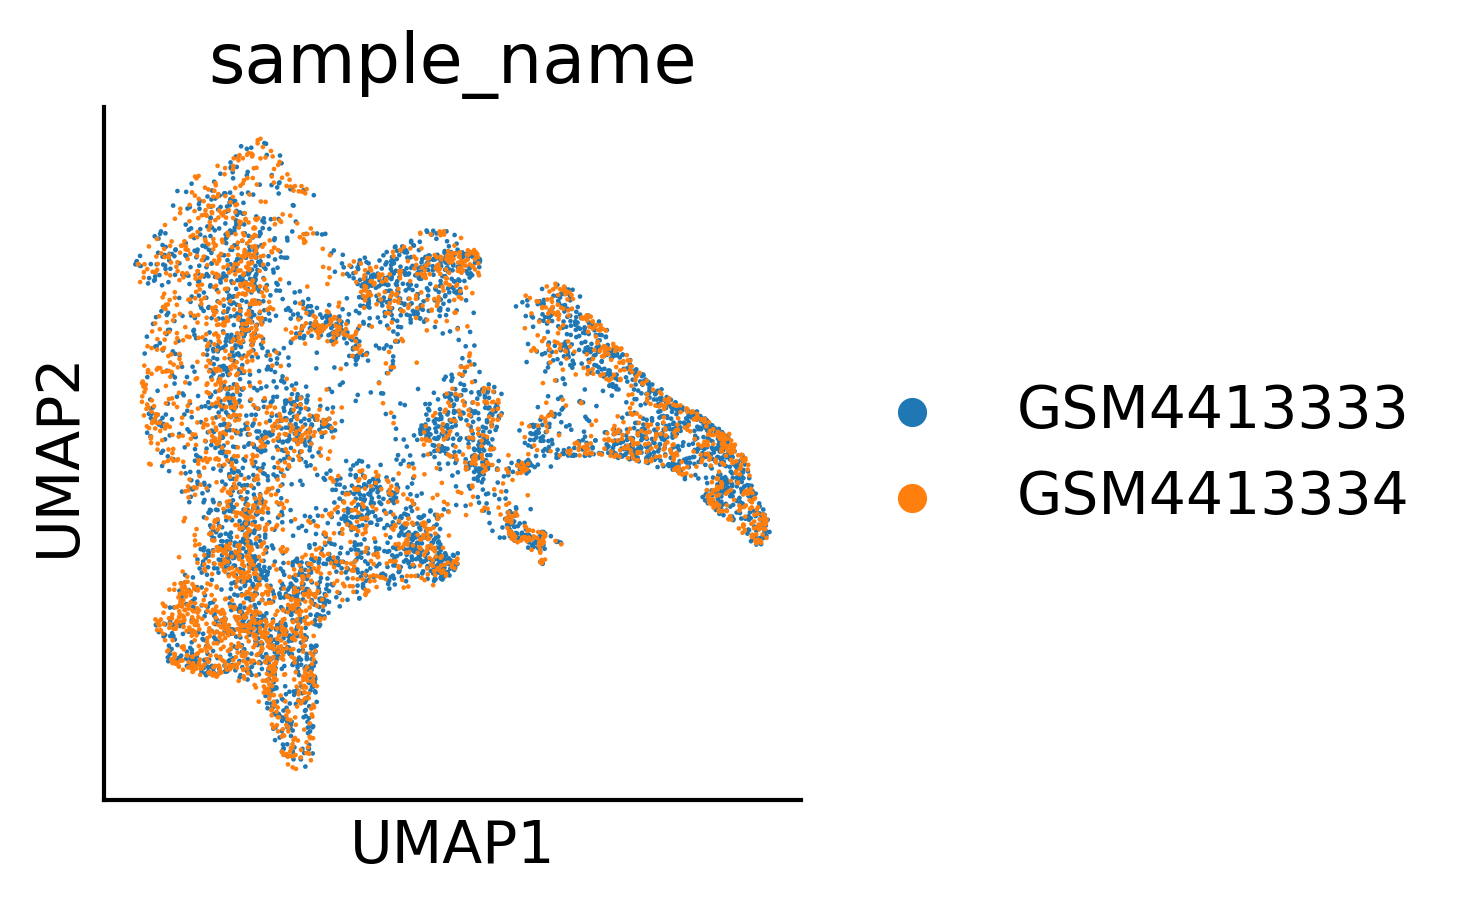

In [2478]:
fig,ax=createFig()
fig.set_size_inches(3,3)
sc.pl.umap(bowling_adata[bowling_adata.obs['sample_name'].isin(['GSM4413333','GSM4413334'])], color='sample_name', s=5, ax=ax)


In [5]:

bowling_adata.obs['reannotation'].unique()

AnnData object with n_obs × n_vars = 32748 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    uns: 'preference_HSC_colors', 'preference_MPP_colors'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [231]:
sc.write('/home/zhengtuo/songtao/dynamic.h5ad',bowling_adata_)

In [5]:
bowling_adata=cs.hf.read("/home/zhengtuo/songtao/carlin_filter_all2.h5ad")


In [7]:
bowling_adata.obs

sample_name leiden reannotation preference  \
AAACCTGAGCAGGTCA-1_GSM4413333  GSM4413333      3           Mk        NaN   
AAACCTGAGTTTGCGT-1_GSM4413333  GSM4413333     11          Neu        NaN   
AAACCTGCAAGTCATC-1_GSM4413333  GSM4413333     13          Ery        NaN   
AAACCTGCAATGAATG-1_GSM4413333  GSM4413333     18          Ery        NaN   
AAACCTGCAGACGCTC-1_GSM4413333  GSM4413333      9          MPP        NaN   
...                                   ...    ...          ...        ...   
TTTGTTGGTCTTGCTC-1_GSM4413339  GSM4413339      0          HSC        NaN   
TTTGTTGGTGAGTAGC-1_GSM4413339  GSM4413339     12          MPP        NaN   
TTTGTTGTCCGTAGGC-1_GSM4413339  GSM4413339      5          HSC        NaN   
TTTGTTGTCCGTTGGG-1_GSM4413339  GSM4413339     12          MPP        NaN   
TTTGTTGTCGGTAAGG-1_GSM4413339  GSM4413339      0          HSC        NaN   

                              preference_HSC preference_MPP  
AAACCTGAGCAGGTCA-1_GSM4413333            NaN            NaN  
AAACCTGAGTTTGCGT-1_GSM4413333            NaN            NaN  
AAACCTGCAAGTCATC-1_GSM4413333            NaN            NaN  
AAACCTGCAATGAATG-1_GSM4413333            NaN            NaN  
AAACCTGCAGACGCTC-1_GSM4413333            NaN            NaN  
...                                      ...            ...  
TTTGTTGGTCTTGCTC-1_GSM4413339            NaN            NaN  
TTTGTTGGTGAGTAGC-1_GSM4413339            NaN            NaN  
TTTGTTGTCCGTAGGC-1_GSM4413339            NaN            NaN  
TTTGTTGTCCGTTGGG-1_GSM4413339            NaN            NaN  
TTTGTTGTCGGTAAGG-1_GSM4413339            NaN            NaN  

[32748 rows x 6 columns]

In [5]:
# import scanpy as sc
# import scgen

# # Load your data
# adata = bowling_adata.copy()


# # Ensure the data is properly set up
# scgen.SCGEN.setup_anndata(adata, batch_key="sample_name")

# # Create and train the model
# model = scgen.SCGEN(adata)
# model.train(max_epochs=500)

# # Correct batch effects
# adata_corrected = model.batch_removal()


In [2453]:
adata.obs['sample_name'].value_counts()


GSM4413337    228
GSM4413339    132
GSM4413335    117
GSM4413336    112
GSM4413338     76
Name: sample_name, dtype: int64

In [955]:
bowling_adata_.obs['sample_name'].value_counts()

GSM4413336    6024
GSM4413335    5932
GSM4413337    4833
GSM4413339    4716
GSM4413333    4142
GSM4413338    3994
GSM4413334    3107
Name: sample_name, dtype: int64

In [2657]:
# fig,ax=createFig()
# bowling_adata_[~bowling_adata_.obs['sample_name'].isin(['GSM4413333','GSM4413334'])].obs['preference_HSC'].value_counts()
# fig.set_size_inches(3,3)
# sc.pl.umap(bowling_adata_[bowling_adata_.obs['sample_name'].isin(['GSM4413333','GSM4413334'])], color='preference_HSC', s=20, ax=ax)

In [88]:
bowling_adata_=bowling_adata_[bowling_adata_.obs['sample_name'].isin(['GSM4413336'])]
bowling_adata_.obs

sample_name leiden reannotation preference preference_HSC  \
AAACCCAAGTTGAATG-1  GSM4413336      1          HSC        NaN            NaN   
AAACCCAGTGATAGAT-1  GSM4413336     14           My        NaN            NaN   
AAACCCATCAGCGGAA-1  GSM4413336      3          Ery         Mk             Mk   
AAACCCATCGCACTCT-1  GSM4413336      5          HSC        NaN            NaN   
AAACCCATCGCTGTTC-1  GSM4413336      3          Ery        NaN            NaN   
...                        ...    ...          ...        ...            ...   
TTTGTTGAGGGTAATT-1  GSM4413336     11           My        NaN            NaN   
TTTGTTGAGTAGATCA-1  GSM4413336     10          Ery        NaN            NaN   
TTTGTTGCACGATTCA-1  GSM4413336      0          HSC        NaN            NaN   
TTTGTTGCATCACCAA-1  GSM4413336     12          HSC        NaN            NaN   
TTTGTTGTCATAAGGA-1  GSM4413336      1          HSC        NaN            NaN   

                   preference_MPP  
AAACCCAAGTTGAATG-1            NaN  
AAACCCAGTGATAGAT-1            NaN  
AAACCCATCAGCGGAA-1            NaN  
AAACCCATCGCACTCT-1            NaN  
AAACCCATCGCTGTTC-1            NaN  
...                           ...  
TTTGTTGAGGGTAATT-1            NaN  
TTTGTTGAGTAGATCA-1            NaN  
TTTGTTGCACGATTCA-1            NaN  
TTTGTTGCATCACCAA-1            NaN  
TTTGTTGTCATAAGGA-1            NaN  

[6024 rows x 6 columns]

In [1713]:
bowling_adata_.obs['index']=range(bowling_adata_.shape[0])
bowling_adata_[(bowling_adata_.obs['reannotation']=='HSC')].obs['preference_HSC']
df=all_relations
indf=list(df['from_index'].unique())+list(df['to_index'].unique())
adata=bowling_adata_[bowling_adata_.obs['index'].isin(indf)]
bowling_adata_[(bowling_adata_.obs['reannotation']=='HSC')].obs['preference_HSC']



/tmp/ipykernel_68111/1331879583.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bowling_adata_.obs['index']=range(bowling_adata_.shape[0])


AAACCCAAGGAGTACC-1    NaN
AAACCCAAGTTGCTCA-1    NaN
AAACCCAGTTCCTTGC-1    NaN
AAACCCATCGTGGTAT-1    NaN
AAACGAACAAGAAATC-1    NaN
                     ... 
TTTGTTGGTCTTGCTC-1    NaN
TTTGTTGGTGAGTAGC-1    NaN
TTTGTTGTCCGTAGGC-1    NaN
TTTGTTGTCCGTTGGG-1    Ery
TTTGTTGTCGGTAAGG-1     My
Name: preference_HSC, Length: 3539, dtype: category
Categories (2, object): ['Ery', 'My']

In [758]:
bowling_adata_.obs['index']=range(bowling_adata_.shape[0])
#sc.write("/home/zhengtuo/songtao/carlin4.18_all.h5ad",bowling_adata_)


In [2455]:
bowling_adata_.obs['index']=range(bowling_adata_.shape[0])
bowling_adata_=bowling_adata_[~bowling_adata_.obs['sample_name'].isin(['GSM4413333','GSM4413334'])]



In [265]:
bowling_adata_.obs['index']=range(bowling_adata_.shape[0])
bowling_adata_=bowling_adata_[bowling_adata_.obs['sample_name'].isin(['GSM4413339'])]


In [426]:
bowling_adata_
sc.write("/home/zhengtuo/songtao/4.16_ourfate_carlin.h5ad",bowling_adata_)


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [425]:
bowling_adata_

View of AnnData object with n_obs × n_vars = 28606 × 28692
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index'
    obsm: 'X_pca_sct', 'X_umap', 'X_umap_sct'

In [148]:
dic_clone = {}

for i in df.values:
    clone = str(i[4])
    
    # Using setdefault()
    dic_clone.setdefault(clone, []).append(i[7])


In [178]:
dflist_index = [df for _, df in df.groupby(['from_clade'])]
np.random.shuffle(dflist_index)
len(dflist_index)*0.7
dflist_index1=dflist_index[:160]  #36  
dflist_index2=dflist_index[160:]
dflist_index1=pd.concat(dflist_index1)
dflist_index2=pd.concat(dflist_index2)
print(len(dflist_index1))
print(len(dflist_index2))


11165
561


In [1474]:
# #dic_rel={'Ba':6,'Ery':4,'HSC':2,'MPP':3,'Mk':5,'Mo':0,'Neu':1}
# dic_rel={'HSC':3,'Mo':0,'Neu':0,'Ery':1,'Mk':1}
# traincell1=[]
# traincell2=[]
# train_rel=[]
# testcell1=[]
# testcell2=[] 
# test_rel=[]
# for j in range(10):#50
#     cell1=dflist_index1.values.T[3]
#     cell2=dflist_index1.values.T[7]
#     rel=dflist_index1.values.T[10]
#     for i in rel:
#         train_rel.append(dic_rel[i])
#     traincell1+=list(cell1)
#     traincell2+=list(cell2)
#     #train_rel+=list(deep)
#     cell1=dflist_index2.values.T[3]
#     cell2=dflist_index2.values.T[7]
#     testcell1+=list(cell1)
#     testcell2+=list(cell2)
#     rel=dflist_index2.values.T[10]
#     for i in rel:
#         test_rel.append(dic_rel[i])


In [232]:
dic_rel={'HSC':3,'Mo':0,'Neu':0,'Ery':1,'Mk':1}
traincell1=[]
traincell2=[]
train_rel=[]
testcell1=[]
testcell2=[] 
test_rel=[]
for j in range(1):
    cell1=dflist_index1.values.T[3]
    cell2=dflist_index1.values.T[7]
    deep=dflist_index1.values.T[-1]
    for i in range(len(deep)):
        traincell1.append(cell1[i])
        traincell2.append(cell2[i])
    cell1=dflist_index1.values.T[3]
    cell2=dflist_index1.values.T[7]
    deep=dflist_index1.values.T[-1]
    testcell1+=list(cell1)
    testcell2+=list(cell2)
    for i in deep:
        test_rel.append(dic_rel[i])


In [233]:
##No relation的生成
num=5
from_index=list(set(traincell1))
for i in range(len(set(from_index))):
    print(i)
    a=[]
    a.append(from_index[i])
    cell1=np.random.choice(a,num,replace=True)
    cell1=list(cell1)
#     bc=df[df['from_index']==from_index[i]]['from_node'].unique().item()
#     notsamebc=df[df['to_node']!=bc]
    cell1_clone=df[df['from_index']==from_index[i]]['to_clade'].values[0]
    cell2_choice=set(df['to_index'].unique())-set(dic_clone[cell1_clone])

    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([2],num,replace=True)
    rel=list(rel)

    traincell1+=cell1
    traincell2+=cell2
    train_rel+=rel

# from_index=df_test.values.T[1]
# to_index=df_test.values.T[4]
num=5
from_index=list(set(testcell1))
for i in range(len(set(from_index))):
    print(i)
    a=[]
    a.append(from_index[i])
    cell1=np.random.choice(a,num,replace=True)    
    cell1=list(cell1)
    cell1_clone=df[df['from_index']==from_index[i]]['to_clade'].values[0]
    cell2_choice=set(df['to_index'].unique())-set(dic_clone[cell1_clone])

    cell2=np.random.choice(list(set(cell2_choice)),num,replace=False)
    cell2=list(cell2)
    rel=np.random.choice([2],num,replace=True)
    rel=list(rel)

    testcell1+=cell1
    testcell2+=cell2
    test_rel+=rel


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [261]:

traincell1=np.loadtxt('/home/zhengtuo/songtao/1dynamictraincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/1dynamictraincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/1dynamictestcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/1dynamictestcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/1dynamictrainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/1dynamictestrel.txt',dtype=int)


In [262]:
dic_train={}
dic_test={}
for i in train_rel:  
    dic_train[i] = dic_train.get(i, 0) + 1
print(dic_train)
for i in test_rel:  
    dic_test[i] = dic_test.get(i, 0) + 1
print(dic_test)

{0: 6421, 1: 4744, 2: 3165}
{0: 6421, 1: 4744, 2: 3165}


In [235]:
np.savetxt('/home/zhengtuo/songtao/1dynamictraincell1.txt',traincell1)
np.savetxt('/home/zhengtuo/songtao/1dynamictraincell2.txt',traincell2)
np.savetxt('/home/zhengtuo/songtao/1dynamictestcell1.txt',testcell1)
np.savetxt('/home/zhengtuo/songtao/1dynamictestcell2.txt',testcell2)
np.savetxt('/home/zhengtuo/songtao/1dynamictrainrel.txt',train_rel,fmt='%d')
np.savetxt('/home/zhengtuo/songtao/1dynamictestrel.txt',test_rel,fmt='%d')


In [292]:
from math import sqrt

import torch
import torch.nn as nn
num_relations=3
len_geneExp=15772
len_embedding=256
learning_rate=0.0001
num_epoch=50
batchsize=512
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k # 一般默认 Q=K
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        #定义线性变换函数
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4)  # 输入通道数为1，输出通道数为6
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  # 输入通道数为6，输出通道数为16
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        # 输入x -> conv1 -> relu -> 2x2窗口的最大池化
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        # # 输入x -> conv2 -> relu -> 2x2窗口的最大池化
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        # # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        x=self.dropout(x)
        x=self.fc1(x)
        return x
geneEnc=nn.Sequential(
    nn.Dropout(),
    nn.Linear(len_geneExp, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
     nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)

geneDec = nn.Sequential(
    nn.Linear(len_embedding, 512),
    nn.Linear(512, len_geneExp),
)
genemap = nn.Sequential(
     #nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)
model=CNN()
device = torch.device("cuda:7")
device2 = torch.device("cuda:7")

In [293]:
from sklearn.metrics import confusion_matrix
TwoNets_path='/home/zhengtuo/songtao/dynamic.pth'
checkpoint = torch.load(TwoNets_path,map_location='cuda:0')
model.load_state_dict(checkpoint['model'])
model.to(device2)
geneEnc.load_state_dict(checkpoint['geneEnc'])
geneEnc.to(device2)
model.eval()
geneEnc.eval()
genemap.load_state_dict(checkpoint['genemap'])
genemap.to(device2)
genemap.eval()

Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=256, bias=True)
)

100%|█████████████████████████████████████| 1558/1558 [00:00<00:00, 2540.07it/s]
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


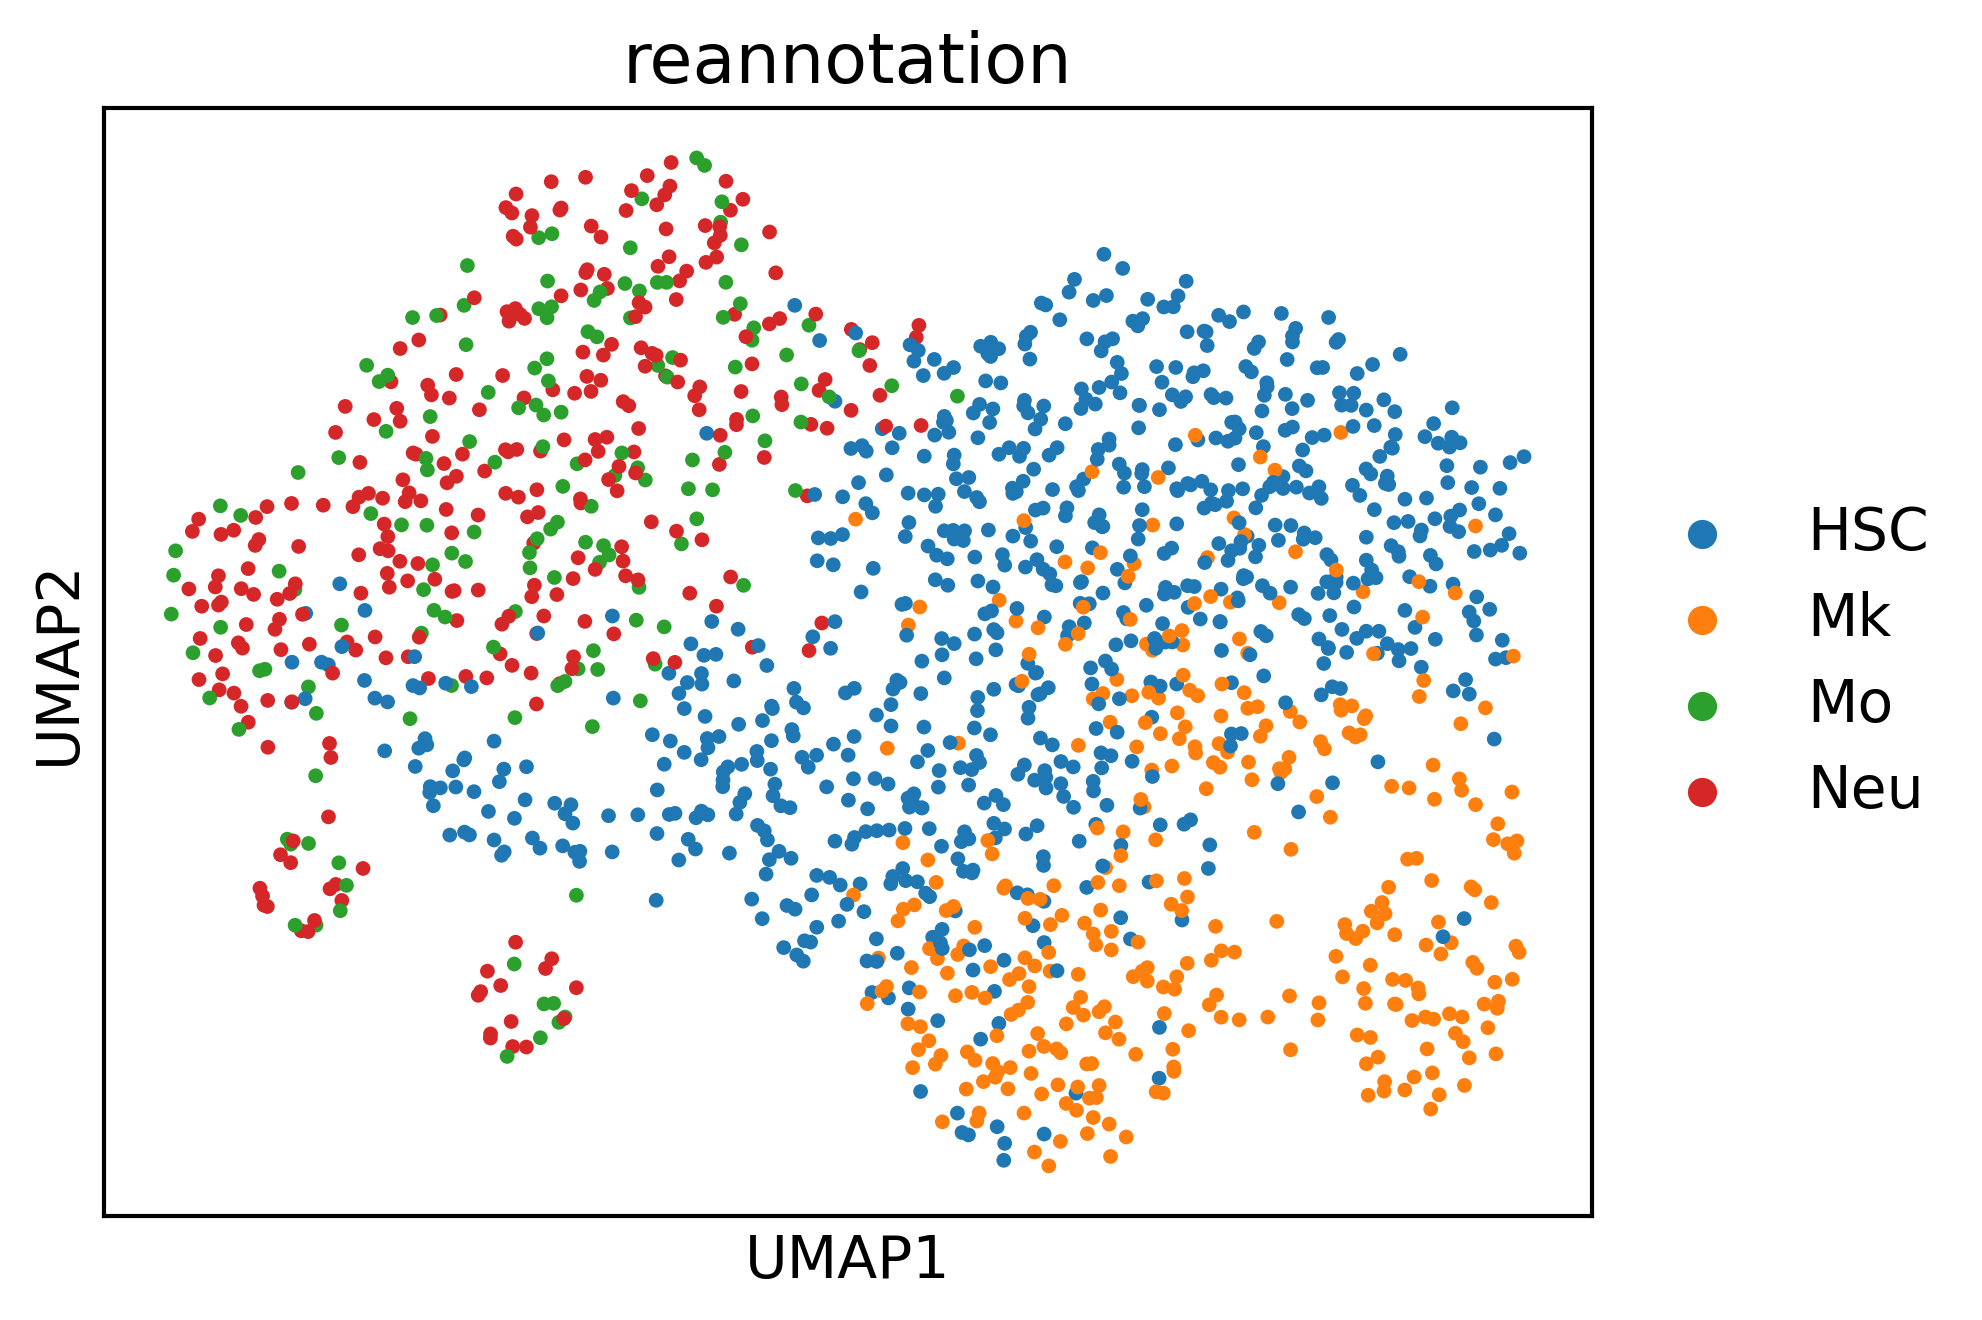

In [294]:
Embeddings_path = '/home/zhengtuo/songtao/dynamic2.txt.npz' # txt dir to save cell embeddings
from tqdm import trange
geneEnc.to(device2)
all_embeddings = []
with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = 1*adata.X[i]
        geneExp = torch.tensor(x).to(device2)
        geneExp=torch.reshape(geneExp,(1,15772))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
    np.savez(Embeddings_path,all_embeddings)

import torch
import umap
n= np.load( '/home/zhengtuo/songtao/dynamic2.txt.npz')
n=torch.tensor(n['arr_0'])
n=torch.reshape(n,(1558,256))#4149
adata.obsm["X_pca"] = n
cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=2)
# cs.pl.embedding(adata2, color="deep")
sc.pl.umap(adata, color="reannotation", s=50)


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


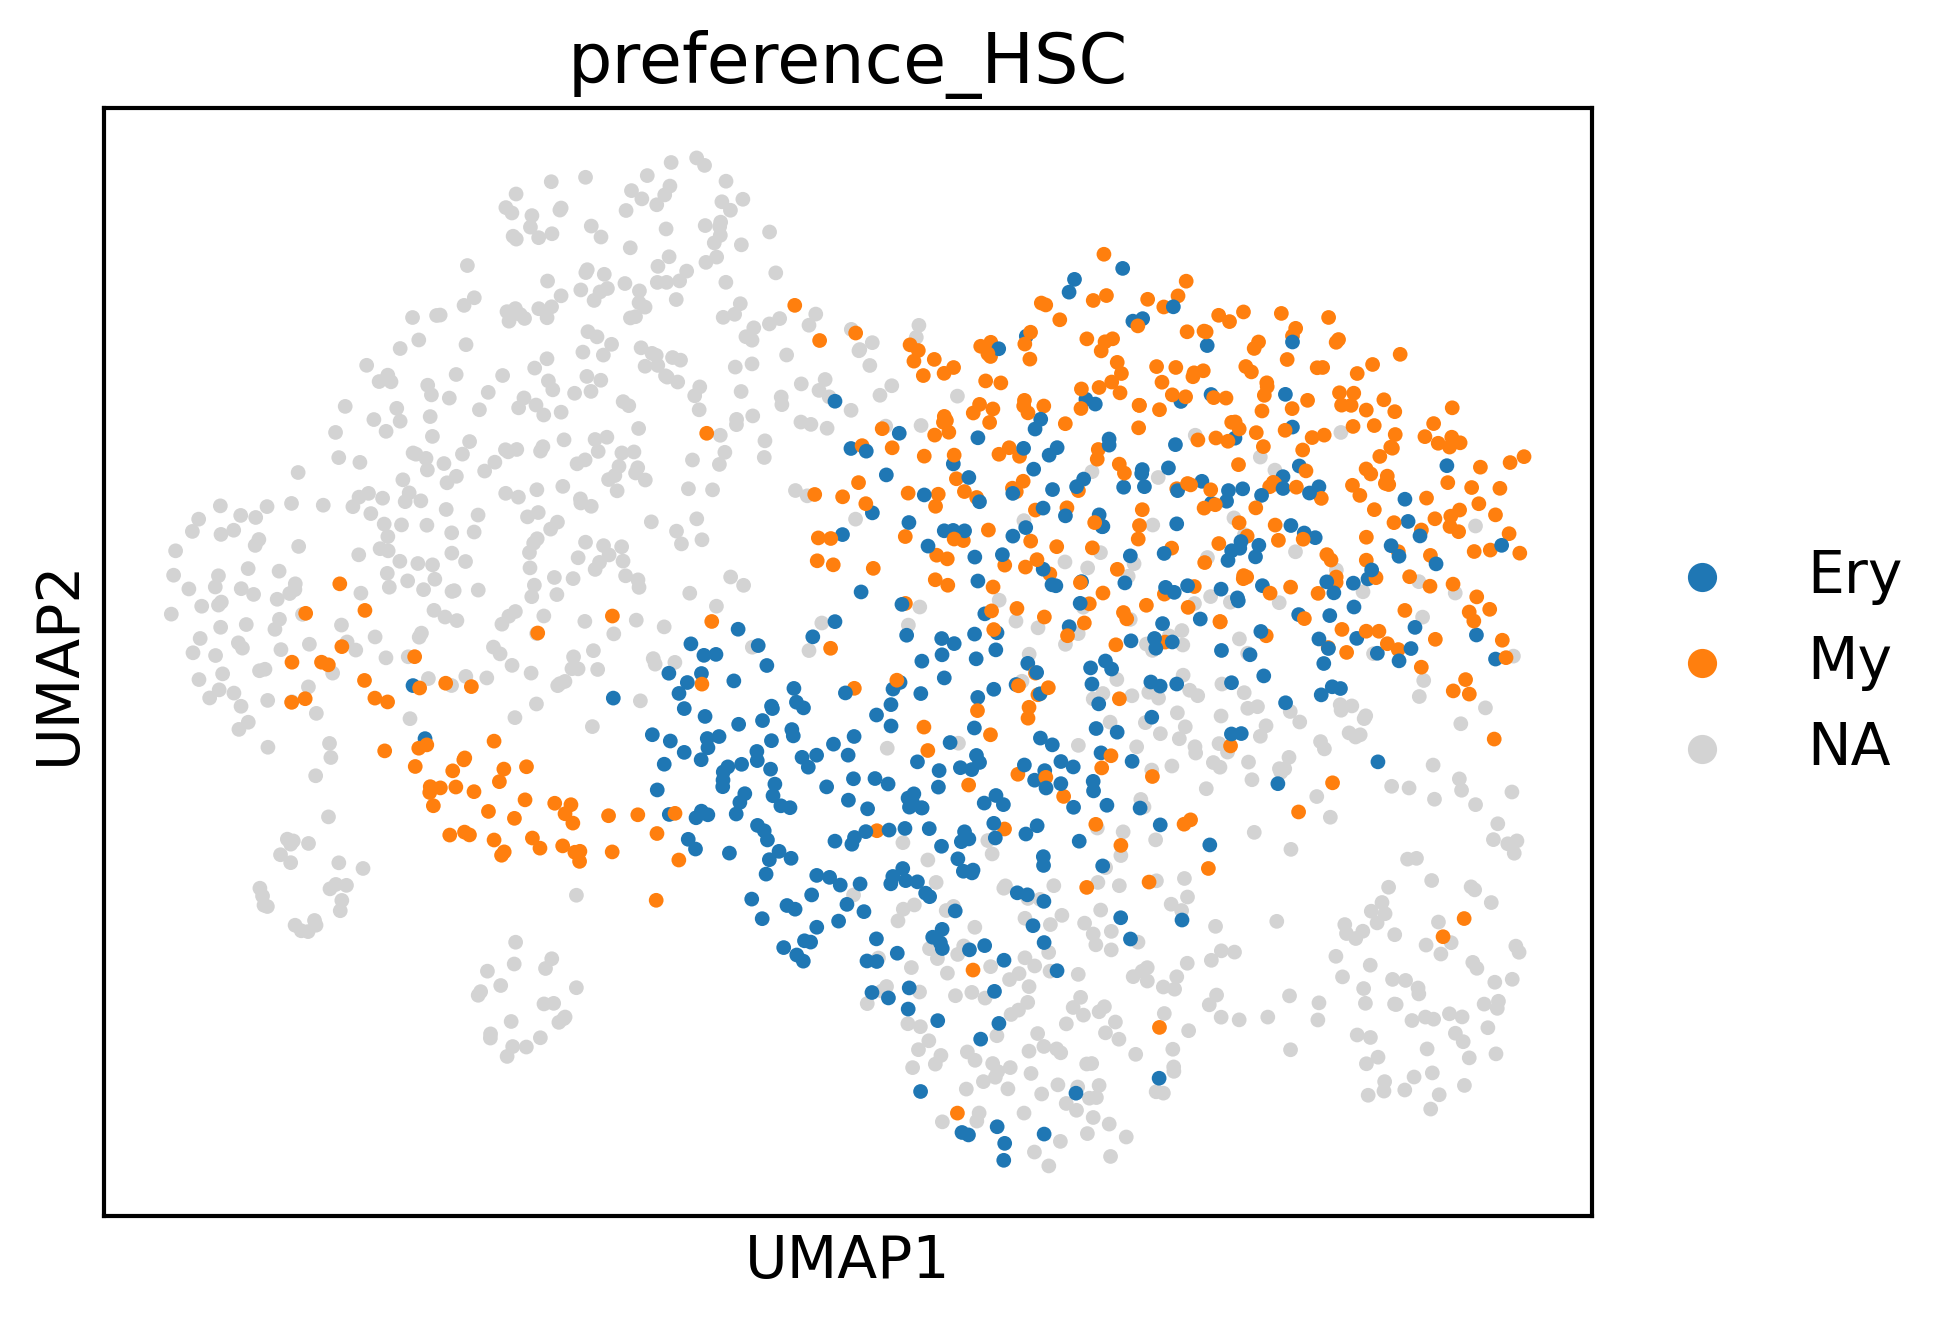

In [295]:
#adata3=adata[(adata.obs['reannotation']=='HSC')]
#adata3=adata3[(adata3.obs['preference_HSC'].isin(['Ba','Mk']))]
#adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()
    # adata2=adata[(adata.obs['reannotation']=='HSC')]
# sc.pl.umap(adata2, color="fates", s=50)
adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()
adata2=adata[(adata.obs['reannotation']=='HSC')]
adata2.uns['preference_HSC_colors']=['#1f77b4', '#ff7f0e']
sc.pl.umap(adata, color="preference_HSC", s=50)



/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


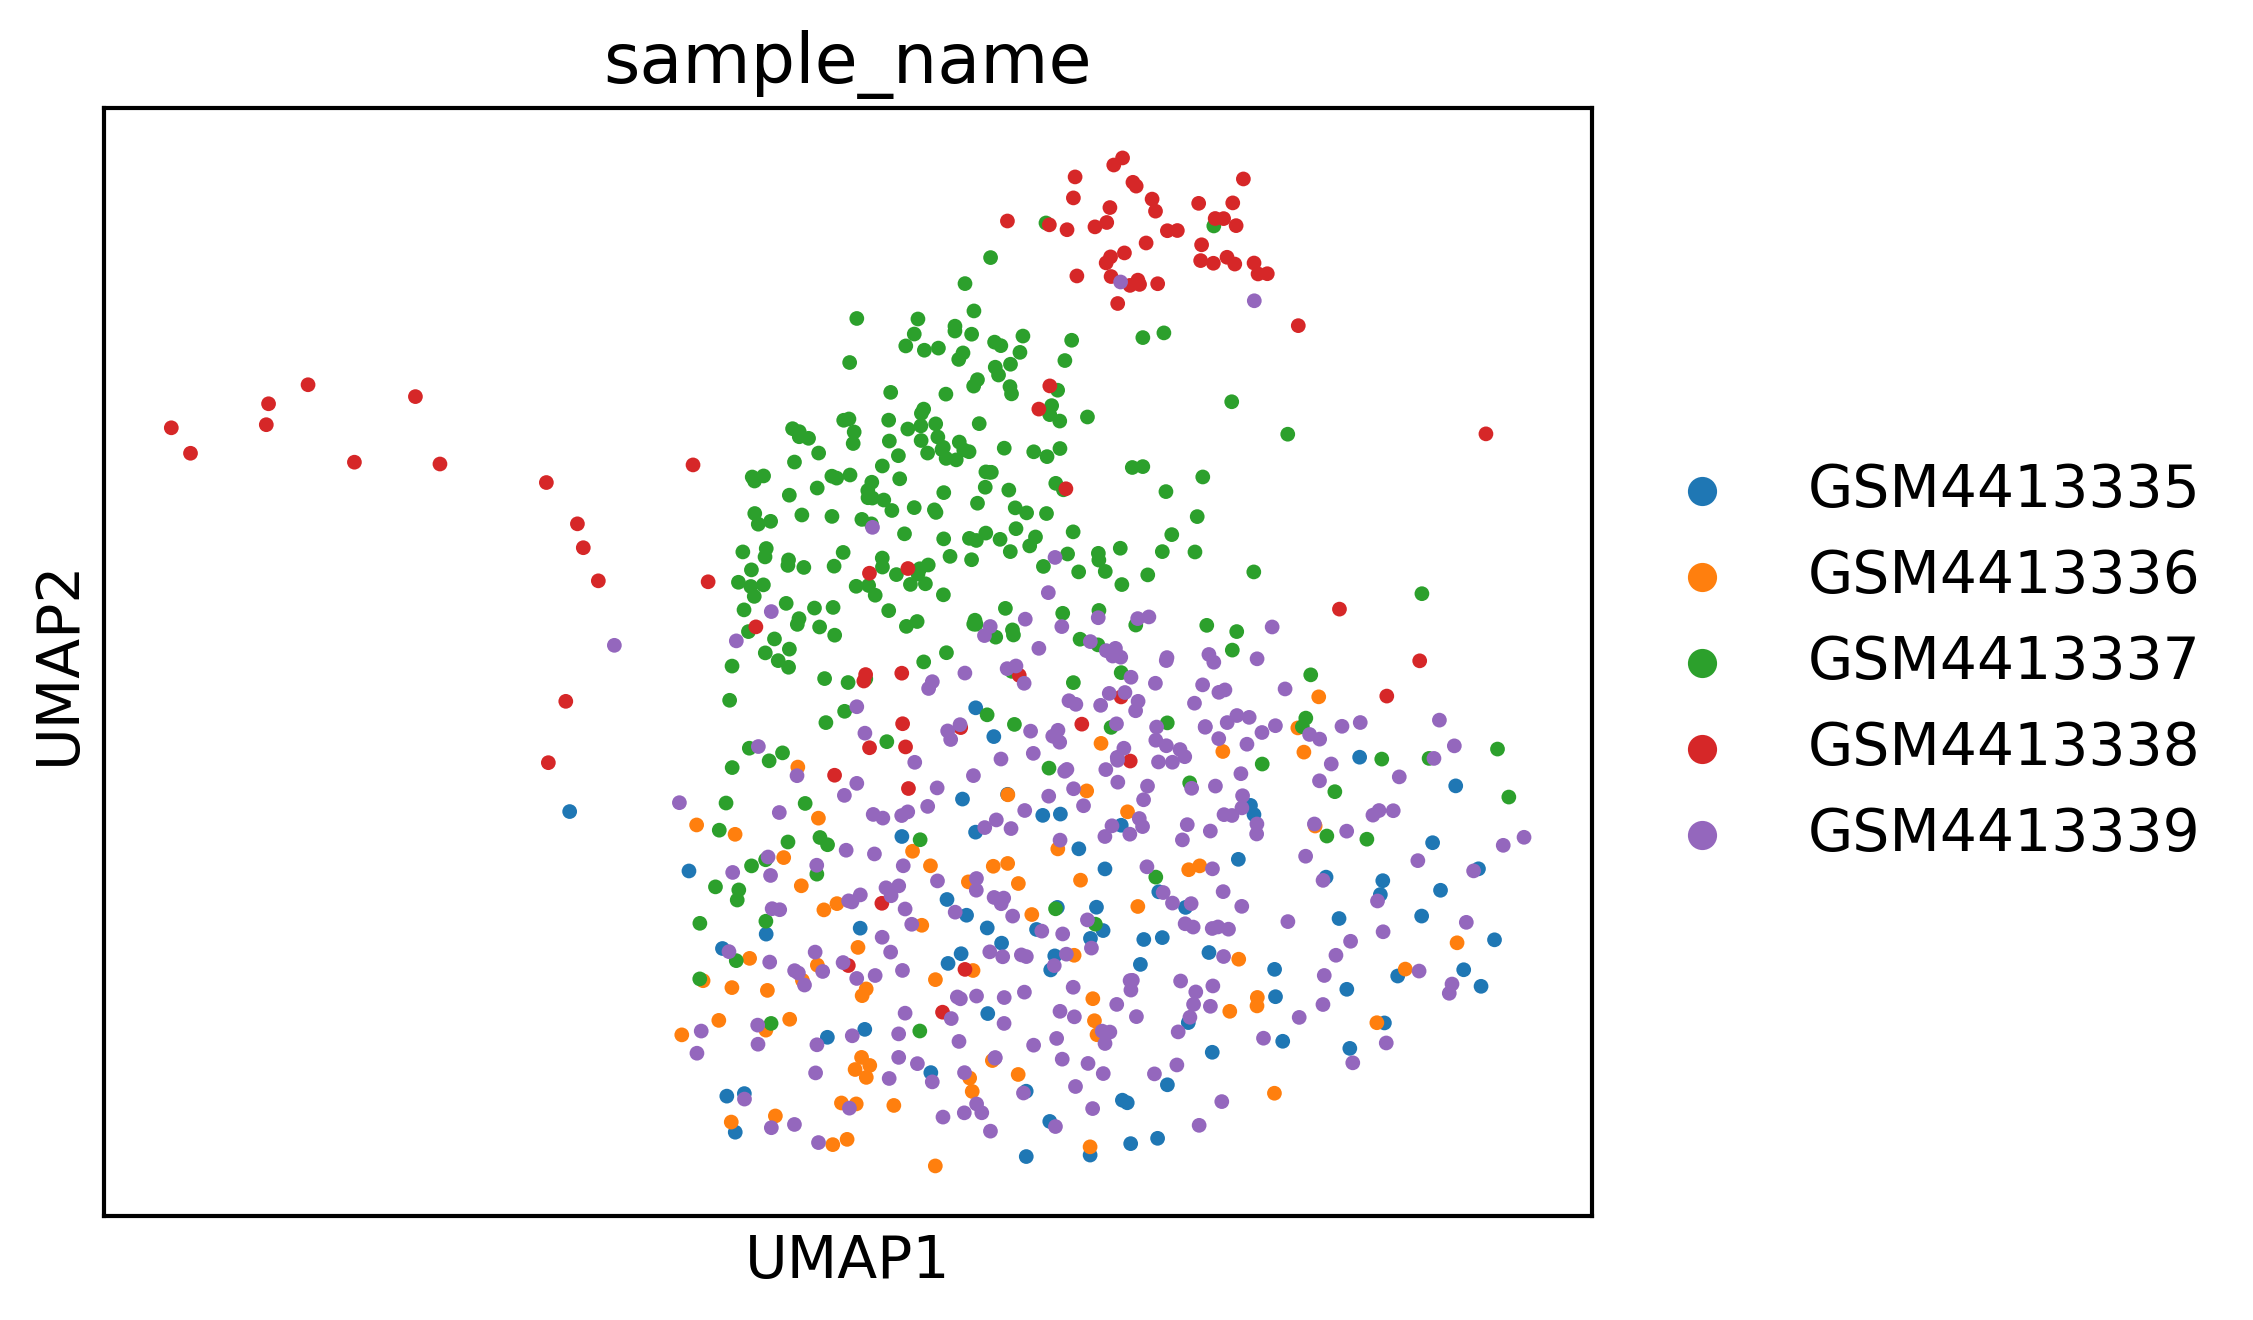

In [269]:
sc.pl.umap(adata2, color="sample_name", s=50)



In [296]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor


In [297]:
mapembedding = []
genemap.to(device2)
with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = 1*adata.X[i]
        geneExp = torch.tensor(x).to(device2)
        geneExp=torch.reshape(geneExp,(1,15772))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        geneEmbedding=genemap(geneEmbedding)
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        mapembedding.append(geneEmbedding)
all_embeddings=np.array(all_embeddings)
all_embeddings.shape
mapembedding=np.array(mapembedding)
mapembedding.shape

adata.obsm['geneEnc']=all_embeddings
adata.obsm['genemap']=mapembedding
#adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()


100%|█████████████████████████████████████| 1558/1558 [00:01<00:00, 1315.85it/s]


100%|██████████████████████████████████████| 1558/1558 [00:02<00:00, 560.36it/s]


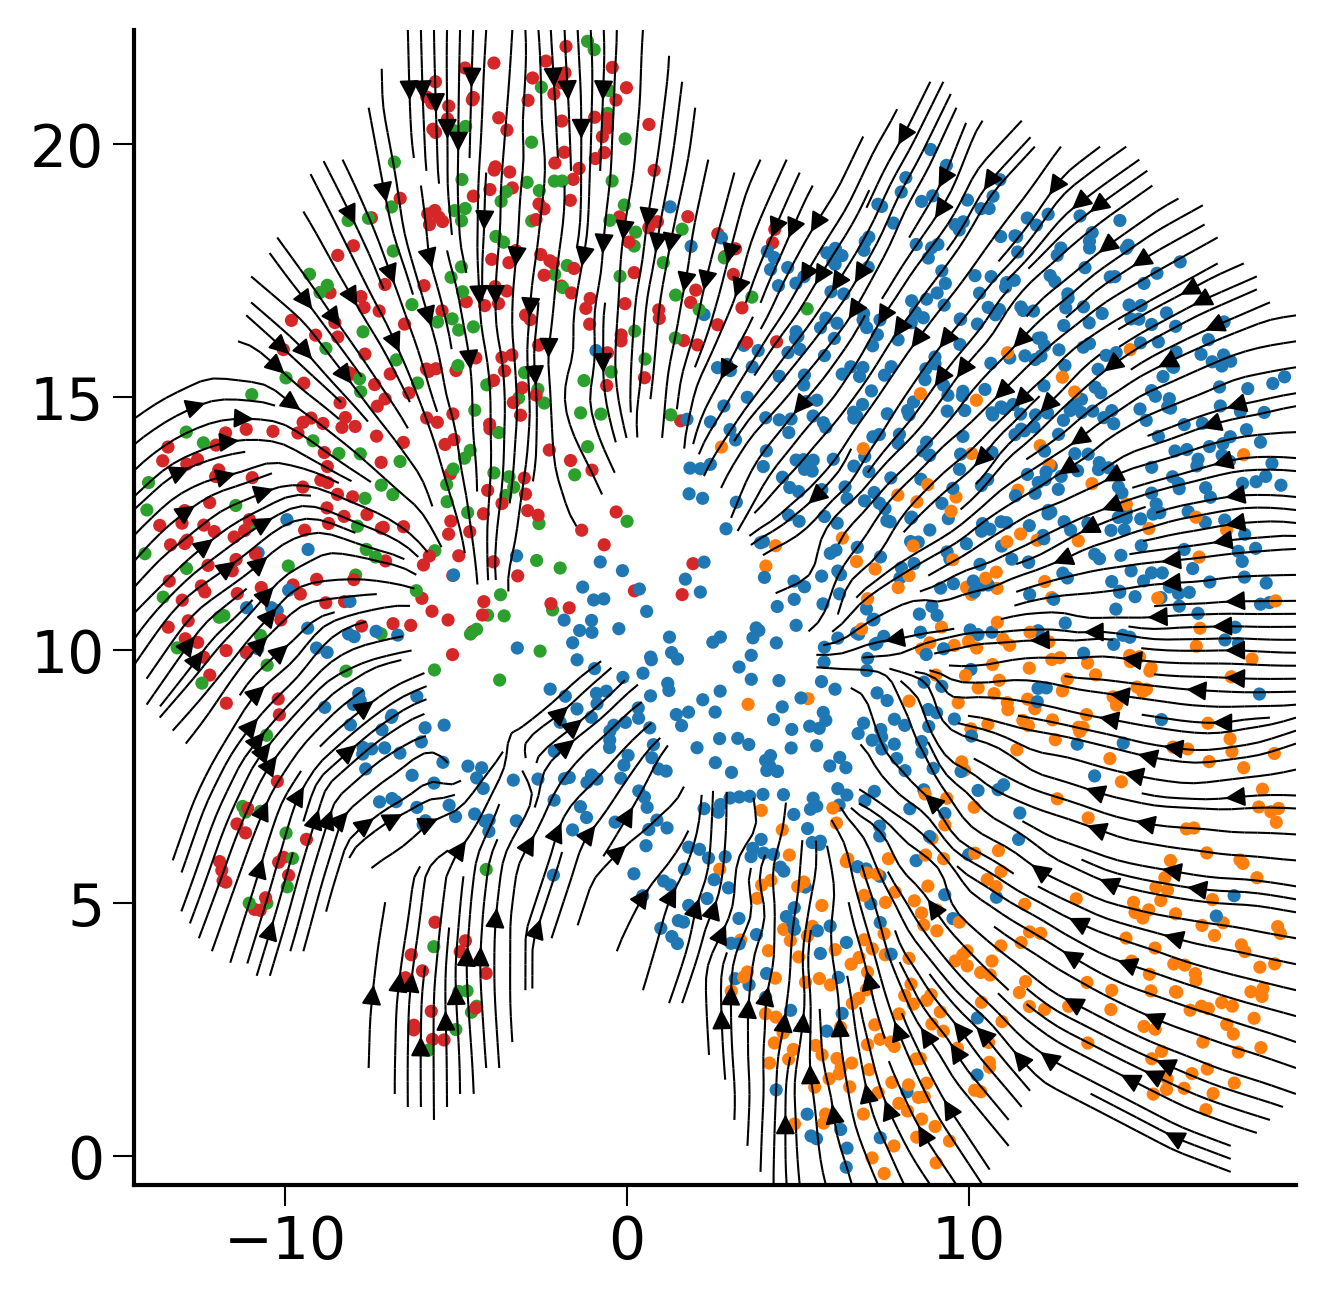

In [298]:
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
import tqdm
adata2=adata


sc.pp.neighbors(adata2)

X = adata2.obsm['geneEnc'][:,0,:]
M = adata2.obsm['genemap'][:,0,:]
N = adata2.obsp['connectivities']
E = adata2.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
dE = []
for i in tqdm.trange(N.shape[0]):

    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata2, 'reannotation')
ax.scatter(E[:,0],E[:,1],s=10, linewidths=0,c=list(map(lambda x: palette[x], adata2.obs['reannotation'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}

ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)


In [163]:
adata.obs[adata.obs['index']==18469]

Empty DataFrame
Columns: [sample_name, leiden, reannotation, preference, preference_HSC, preference_MPP, index]
Index: []

In [299]:
dic_true={}
for i in range((adata.shape[0])):
    if(adata.obs['preference_HSC'][i]=='Ery'):
        dic_true[adata.obs['index'][i]]=1
    elif(adata.obs['preference_HSC'][i]=='My'):
        dic_true[adata.obs['index'][i]]=0
    else:
        dic_true[adata.obs['index'][i]]=2

In [300]:
#all_cell1=[]
# all_cell2=[]
all_cell1=list(set(list(traincell1)+list(testcell1)))
all_cell2=list(set(list(traincell2)+list(testcell2)))
# testcell1=np.array(testcell1).astype(int)
# testcell2=np.array(testcell2).astype(int)
# all_cell1=list(set(list(testcell1)))
# all_cell2=list(set(list(testcell2)))

##### import torch
# n= np.load("/home/songtao/CNNWithMap-12rel.pth.txt.npz")
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(130887,256))
# adata.obsm["X_pca"] = n
#dic2={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:10,10:9,11:0,12:1,13:2,14:3,15:4,16:5,17:6,18:7,19:8,20:10,21:9}
from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(((all_cell1))[idx])
        gene=bowling_adata.X[i]
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)
        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(((all_cell2))[idx])
        gene=bowling_adata.X[i]
        gene=torch.tensor(gene)
        genetype=bowling_adata.obs['reannotation'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(all_cell1))
otherdataset=otherDataset(len(all_cell2))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len((all_cell1)), num_workers=4, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)



In [285]:
true=0
dic={'HSC':3,'Mo':0,'Neu':0,'Mk':1,'Ery':1}
cudaid = 'cuda:7'
# dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
#        'Baso':5, 'Eos':6}
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    #cell1=torch.reshape(cell1,(hang,256))
    true_labels=onebatch1[1]
    #print(cell1)
    #print(true_labels)
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,3))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        #print(genetype)
        geneEmbs = torch.cat((cell1, cell2), -1)
        geneEmbs=torch.reshape(geneEmbs,(geneEmbs.shape[0],1,geneEmbs.shape[1]))
        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,3))
        #print(outputs)
        outputs=outputs.argmax(-1)

        for num in range(hang):
            if(int(outputs[num])!=2):
                pre_labels[num][int(outputs[num])]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    #print(pre_labels)
    #print(pre_labels)
    pre_labels=np.argsort(-pre_labels)
    #print(pre_labels)
    pre_labels=pre_labels.T[0]
    #print(pre_labels)
    true+=np.count_nonzero(pre_labels==true_labels)
    #np.savetxt('/home/songtao/matrix.txt',matrix1)
    del cell1
    torch.cuda.empty_cache()
 


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [286]:
true/len(all_cell1)

0.8562401263823065

In [287]:
all_cell1=np.array(all_cell1).astype(int)
item=list((all_cell1))
dic_fate={}
dic1={0:'My',1:'Ery'}
#dic1={0:'multilineage',1:'myelo-erythroid restricted'}
for i in range(len(item)):
    dic_fate[item[i]]=dic1[int(pre_labels[i])]

In [288]:
adata.obs['fate_pred']=None
adata.obs['fate_pred']=adata.obs['index'].map(dic_fate)
adata.obs

sample_name leiden reannotation preference preference_HSC  \
AAACGCTTCTTCCTAA-1  GSM4413335      3           Mk        NaN            NaN   
AAAGGATGTCAGACTT-1  GSM4413335     17          HSC        NaN             My   
AAAGGATGTGGGTATG-1  GSM4413335     11          Neu        NaN            NaN   
AACAAAGAGTAGGATT-1  GSM4413335      1          HSC        NaN             My   
AACAACCTCATGCTAG-1  GSM4413335      5          HSC        NaN             My   
...                        ...    ...          ...        ...            ...   
TTTGATCTCGGCATCG-1  GSM4413339      1          HSC        NaN             My   
TTTGGAGGTACCCGCA-1  GSM4413339     20          HSC        NaN             My   
TTTGGAGTCGGCATCG-1  GSM4413339      4          Neu        NaN            NaN   
TTTGGTTCAATGAGCG-1  GSM4413339      4          Neu        NaN            NaN   
TTTGTTGTCGGTAAGG-1  GSM4413339      0          HSC        NaN            Ery   

                   preference_MPP      n_counts  index fate_pred  
AAACGCTTCTTCCTAA-1            NaN  12402.601562   7269       NaN  
AAAGGATGTCAGACTT-1            NaN  12192.313477   7278        My  
AAAGGATGTGGGTATG-1            NaN  11071.074219   7279       NaN  
AACAAAGAGTAGGATT-1            NaN  12304.815430   7308       NaN  
AACAACCTCATGCTAG-1            NaN  13463.123047   7319       NaN  
...                           ...           ...    ...       ...  
TTTGATCTCGGCATCG-1            NaN  12336.791016  32726        My  
TTTGGAGGTACCCGCA-1            NaN  12059.296875  32731        My  
TTTGGAGTCGGCATCG-1            NaN  11210.212891  32735       NaN  
TTTGGTTCAATGAGCG-1            NaN  10302.634766  32737       NaN  
TTTGTTGTCGGTAAGG-1            NaN  15689.689453  32747       NaN  

[1558 rows x 9 columns]

/tmp/ipykernel_151882/2678103946.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata3.obs['fate_pred'] = None
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


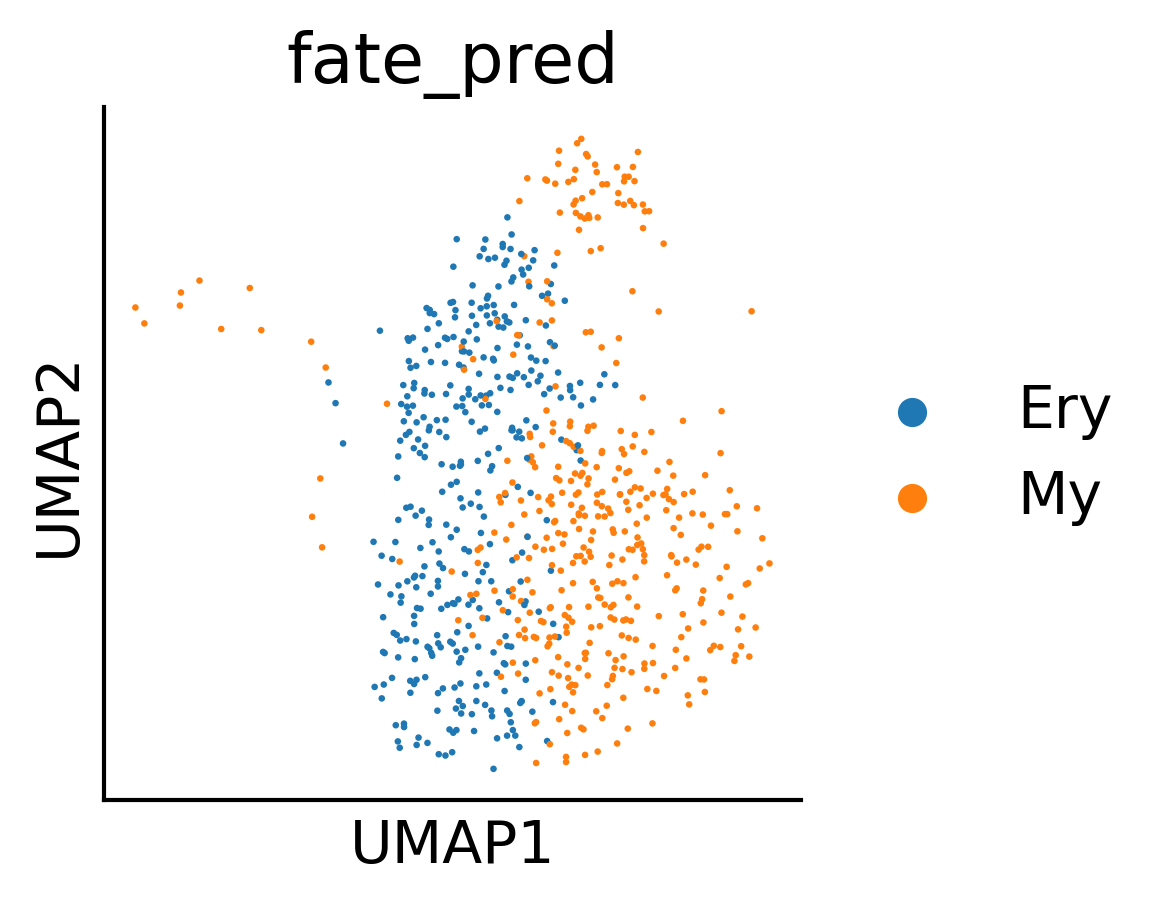

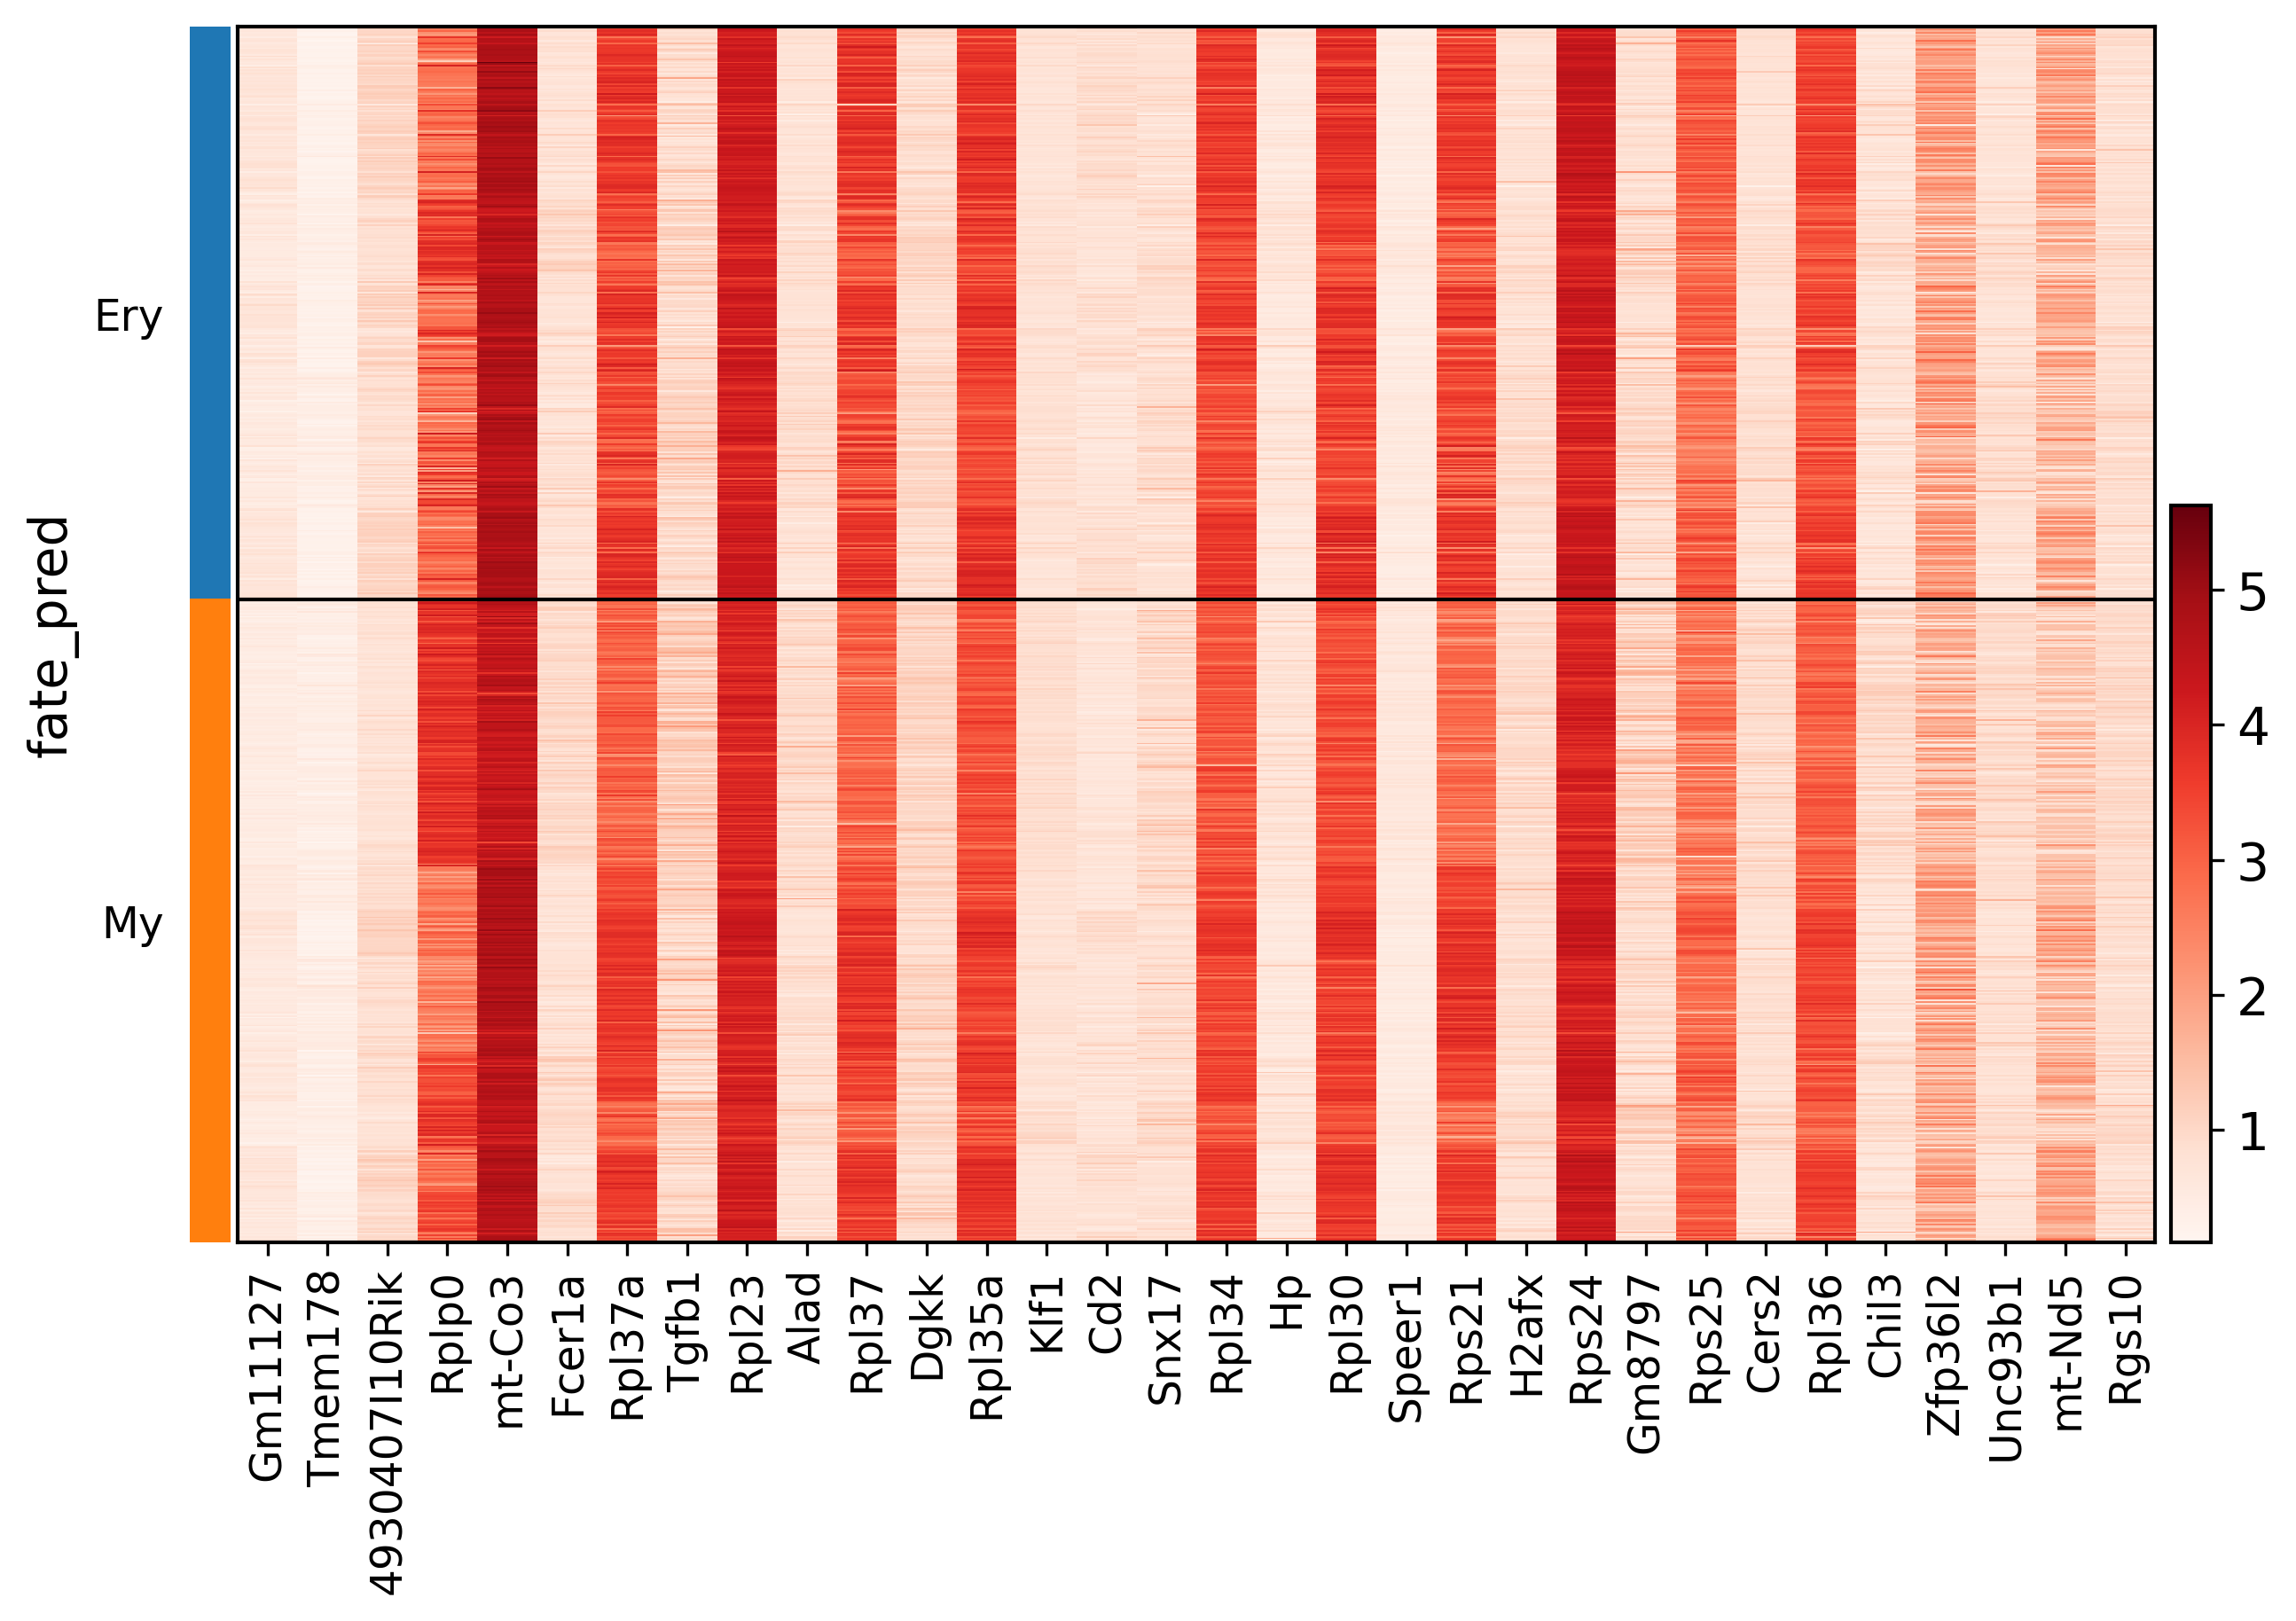

In [289]:

adata3=adata[(adata.obs['reannotation']=='HSC')]
from sklearn.neighbors import KNeighborsClassifier
knnc = KNeighborsClassifier(n_neighbors=13)
knnc.fit(adata3[list(map(lambda x: type(x) ==str, adata3.obs['fate_pred']))].obsm["X_pca"],
        adata3[list(map(lambda x: type(x) ==str, adata3.obs['fate_pred']))].obs['fate_pred'])
adata3.obs['fate_pred'] = None
adata3.obs.loc[np.array(list(map(lambda x: x == 'HSC', adata3.obs['reannotation']))),'fate_pred'] = \
    list(knnc.predict(adata3[ 
      np.array(list(map(lambda x: x == 'HSC', adata3.obs['reannotation'])))].obsm['X_pca']))
plt.rcParams['font.size'] = 14
fig,ax=createFig(figsize=(3,3))
sc.pl.umap(adata3,color=['fate_pred'],ax=ax,s=10)
sc.tl.rank_genes_groups(adata3, groupby='fate_pred', method='t-test_overestim_var')

sc.pl.heatmap(
    adata3[list(map(lambda x: type(x) == str, adata3.obs['fate_pred']))],  
    pd.DataFrame(adata3.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), 
    groupby='fate_pred', cmap='Reds'
    
)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


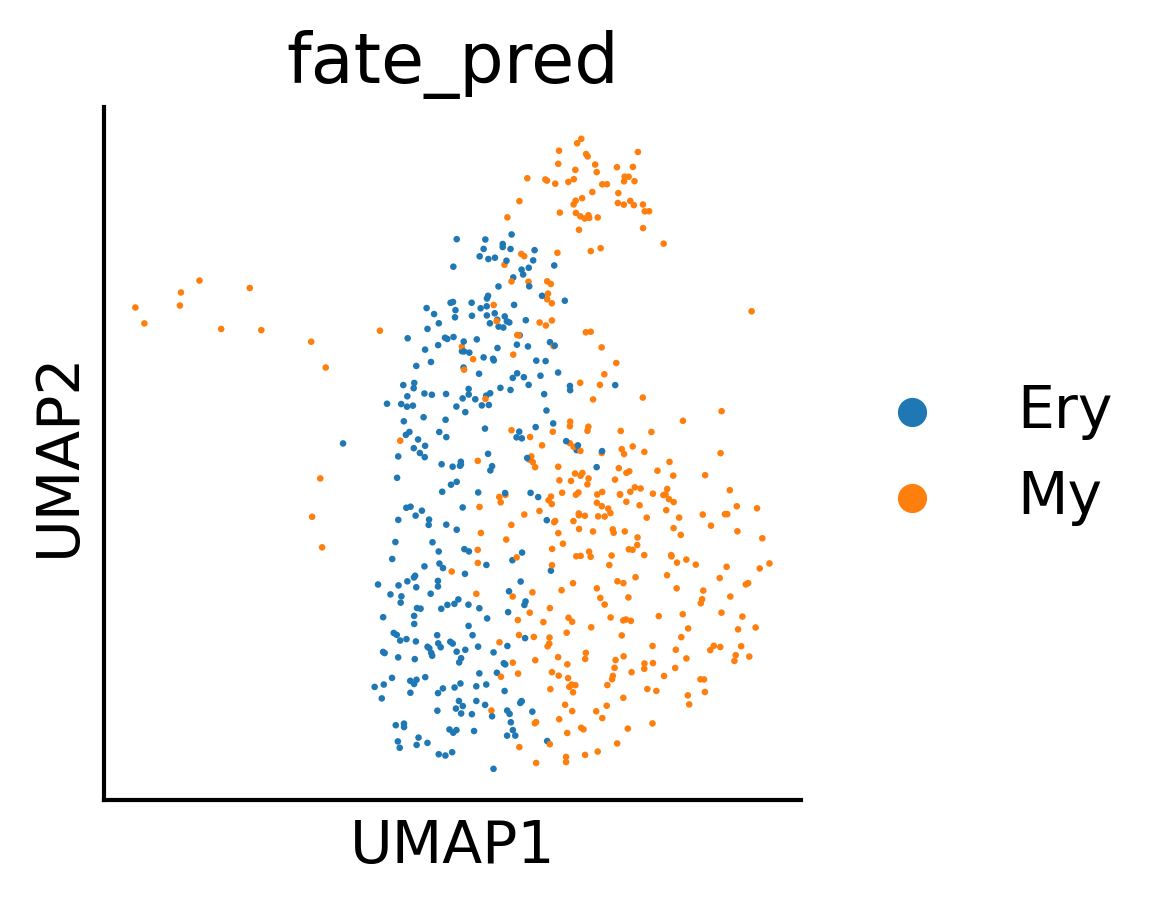

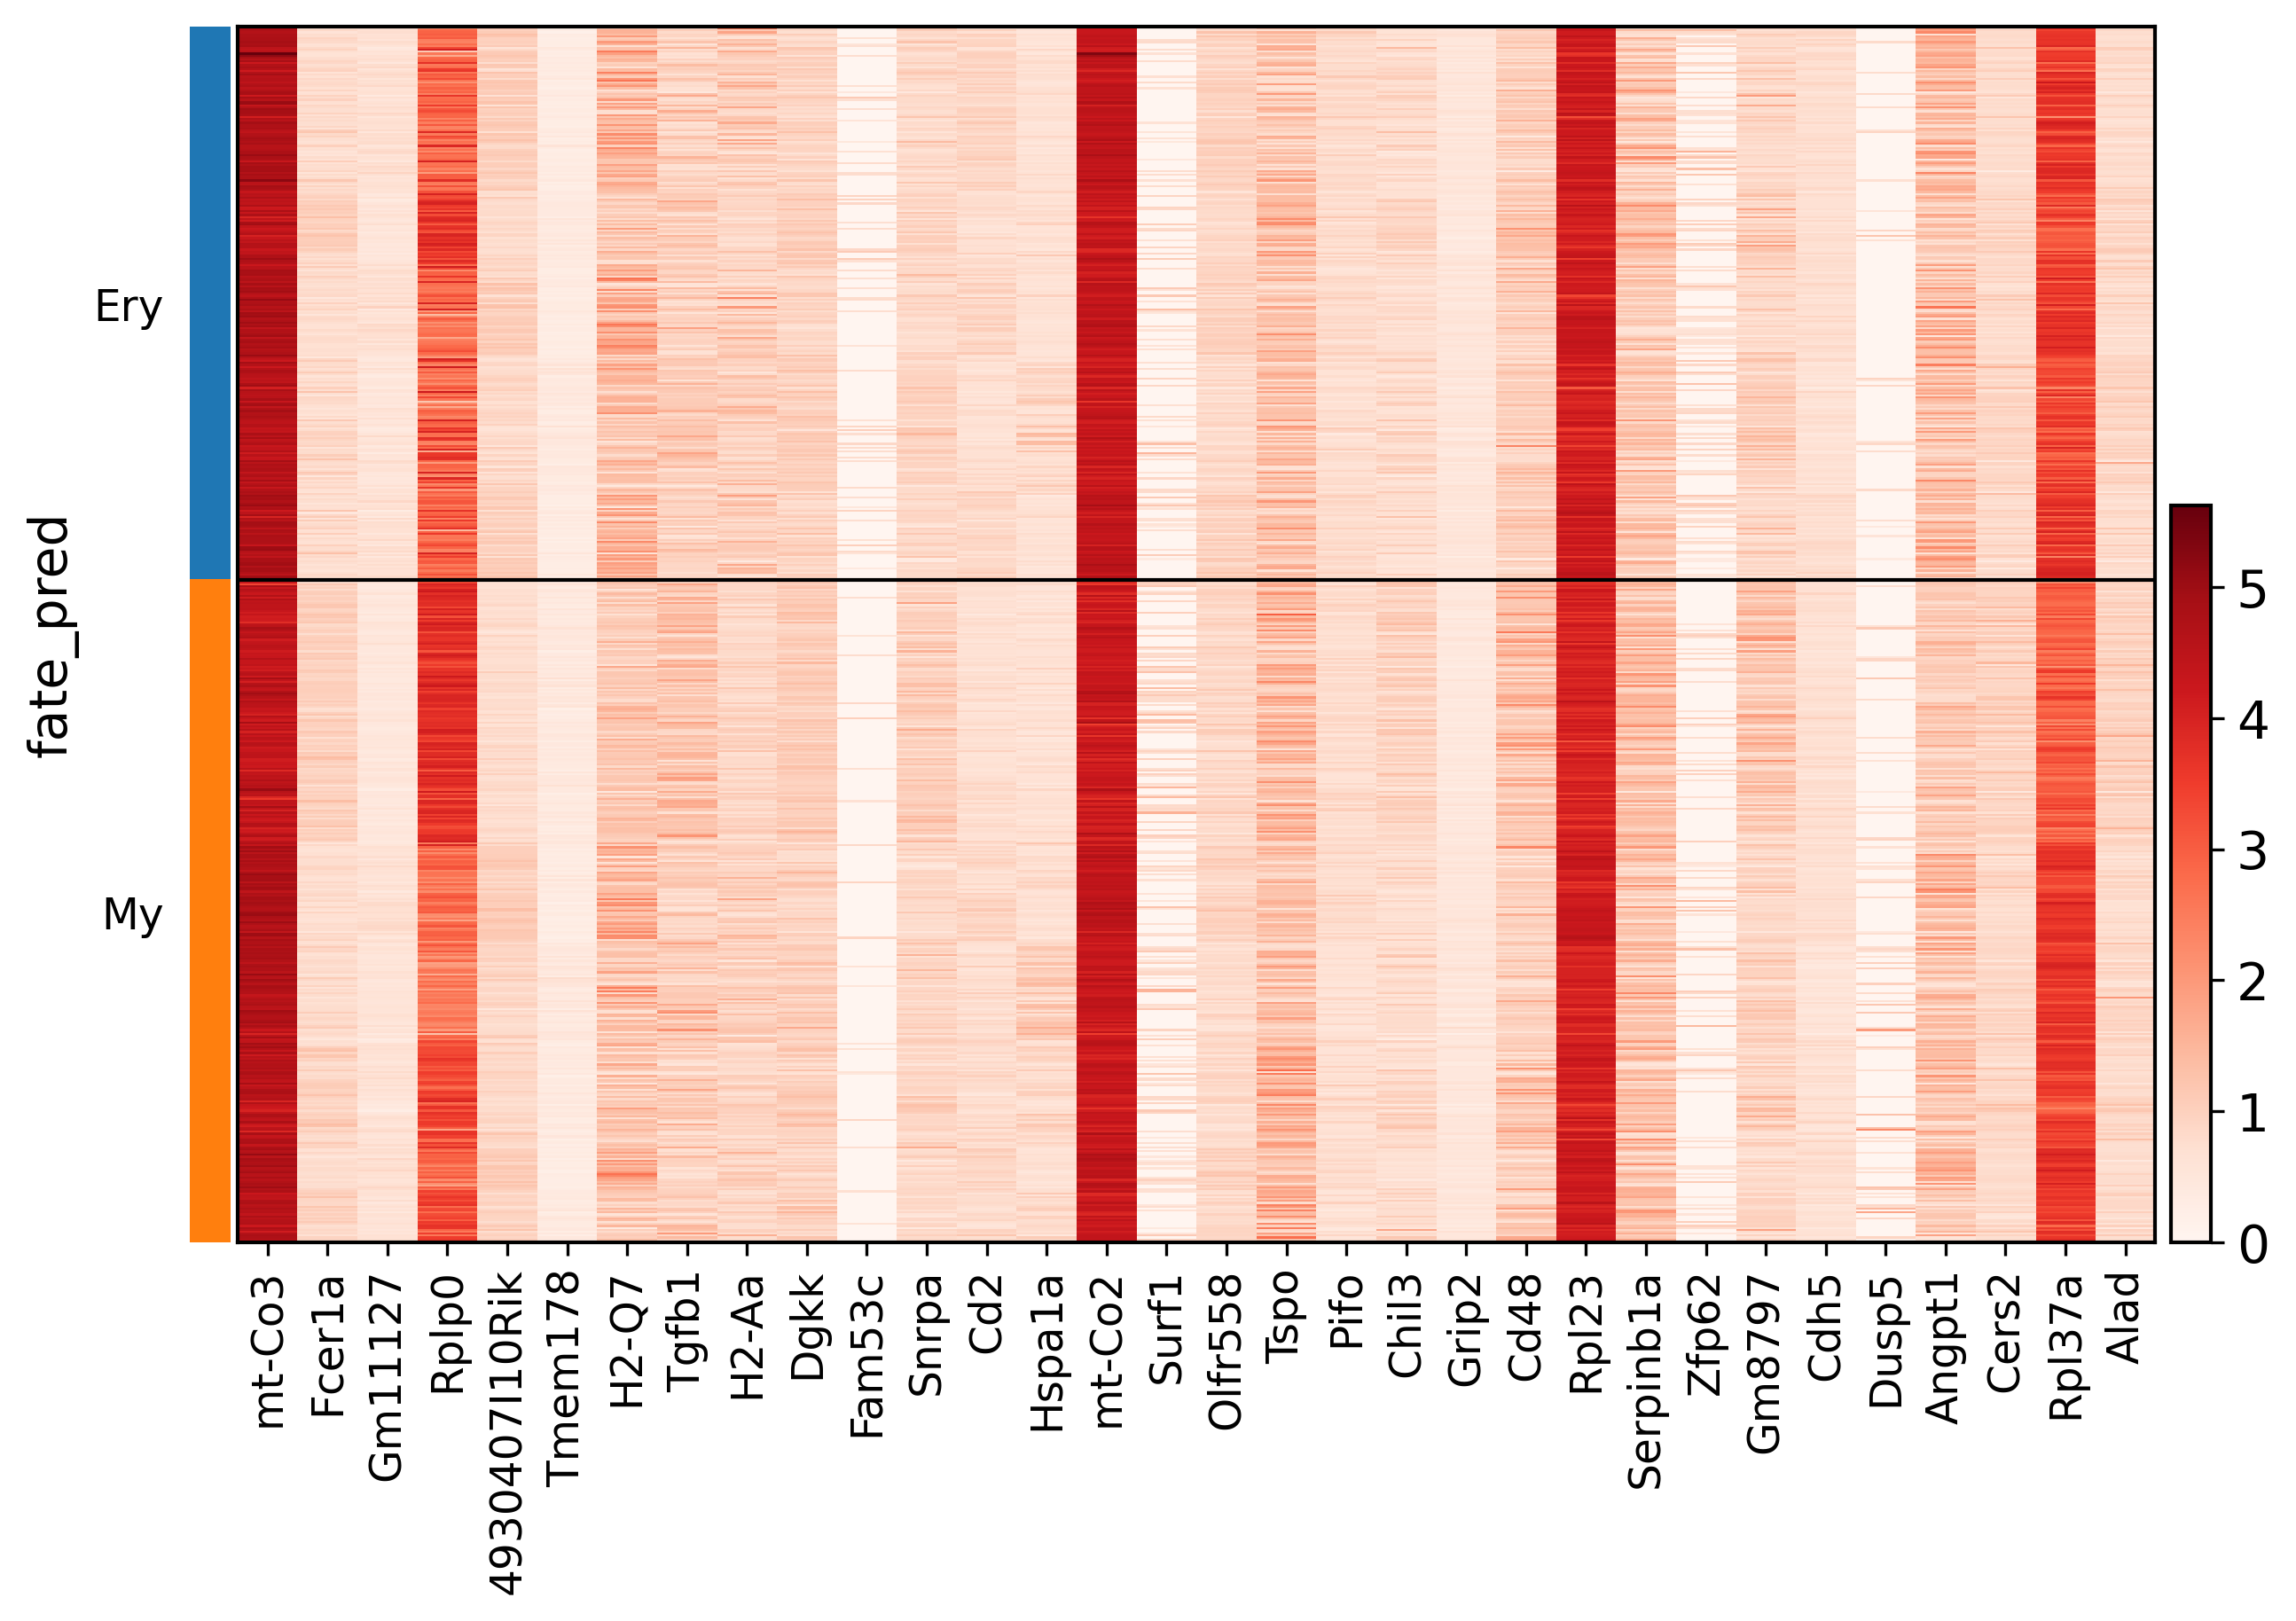

In [290]:
#adata2.uns.pop("log1p")
#adata3=adata2[adata2.obs['cell_type']=='HSC']
adata3=adata2[(adata2.obs['reannotation']=='HSC')&(adata2.obs['fate_pred'].isin(['My','Ery']))]
from sklearn.neighbors import KNeighborsClassifier
# knnc = KNeighborsClassifier(n_neighbors=13)
# knnc.fit(adata3[list(map(lambda x: type(x) ==str, adata3.obs['HSC_preference']))].obsm["X_pca"],
#         adata3[list(map(lambda x: type(x) ==str, adata3.obs['HSC_preference']))].obs['HSC_preference'])
# adata3.obs['fate_pred'] = None
# adata3.obs.loc[np.array(list(map(lambda x: x == 'HSC', adata3.obs['cell_type']))),'fate_pred'] = \
#     list(knnc.predict(adata3[ 
#       np.array(list(map(lambda x: x == 'HSC', adata3.obs['cell_type'])))].obsm['X_pca']))
plt.rcParams['font.size'] = 14
fig,ax=createFig(figsize=(3,3))
sc.pl.umap(adata3,color=['fate_pred'],ax=ax,s=10)
sc.tl.rank_genes_groups(adata3, groupby='fate_pred', method='t-test_overestim_var')

sc.pl.heatmap(
    adata3[list(map(lambda x: type(x) == str, adata3.obs['fate_pred']))],  
    pd.DataFrame(adata3.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), 
    groupby='fate_pred', cmap='Reds'
    
)

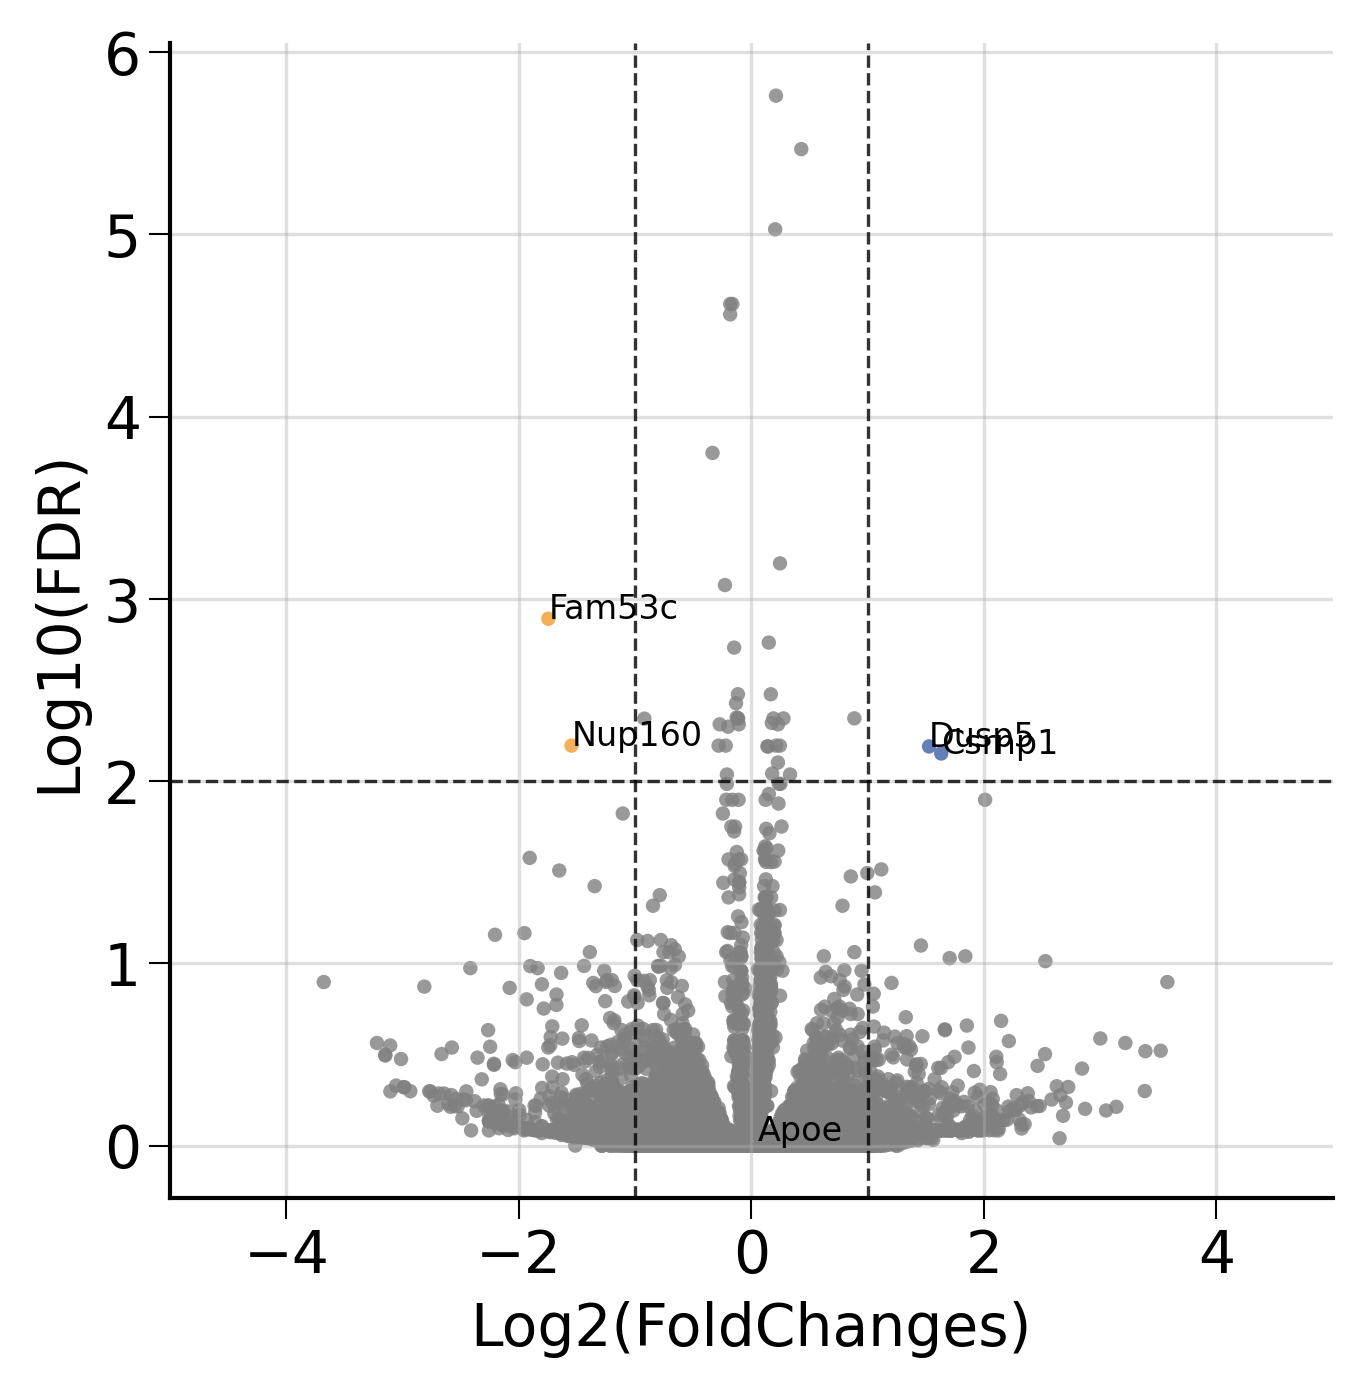

In [291]:
def ScanpyVolcanoPlot(
    adata, 
    axis, 
    use_adjusted_p = True, 
    show_label=True, 
    label_fold_change = 2, 
    label_log_p = 80, 
    label_includes=[],
    add_grid=True, 
    label_size=4, 
    color1 = '#F09D30', 
    color2='#3D5FA6',
    max_abs_fc=5,
):
    fig,ax = createFig()
    log2foldchanges = list(map(lambda x: x[axis], adata3.uns['rank_genes_groups']['logfoldchanges']))
    if use_adjusted_p:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata3.uns['rank_genes_groups']['pvals_adj'])))
    else:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata3.uns['rank_genes_groups']['pvals'])))
    indices = list(map(lambda x: abs(x) < max_abs_fc, log2foldchanges))
    ax.scatter(
        x = np.array(log2foldchanges)[indices],
        y = np.array(log10adjp[indices]),
        s = 12,
        alpha=0.8,
        linewidth = 0,
        c = list(map(lambda x: color1 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] < 0 \
                 else color2 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] > 0 \
                 else 'gray',  np.array(list(zip(log2foldchanges, log10adjp)))[indices]))
    )
    if add_grid:
        ax.axvline(-label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axvline(label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axhline(label_log_p, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.grid(alpha=0.4)
    if show_label:
        indices = list(map(lambda x: abs(x[0]) > label_fold_change and x[1] > label_log_p and abs(x[0]) < max_abs_fc, zip(log2foldchanges, log10adjp)))
        for i,j,s in zip(np.array(log2foldchanges)[indices],np.array(log10adjp)[indices],
             list(map(lambda x: x[axis], adata3.uns['rank_genes_groups']['names'][indices]))):
             ax.text(i,j,s=s, size=label_size)
        for i,j,s in zip(np.array(log2foldchanges),np.array(log10adjp), list(map(lambda x: x[axis], adata3.uns['rank_genes_groups']['names']))):
            if s in label_includes:
                ax.text(i,j,s=s, size=label_size)

    ax.set_xlabel("Log2(FoldChanges)")
    ax.set_ylabel("Log10(FDR)")
    return fig,ax
fig, ax = ScanpyVolcanoPlot(adata3, axis=1,
                           label_fold_change=1,label_log_p=2,
                           label_size=8,show_label=True,label_includes=['Apoe'])
ax.set_xbound(-5,5)
fig.set_size_inches(5,5)


In [2780]:
# sc.pl.umap(adata3, color=pd.DataFrame(adata3.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), cmap='Reds',s=200)



In [2732]:
# fig,ax=createFig(figsize=(3,3))
# sc.pl.umap(adata3,color='Apoe',ax=ax,s=50,cmap='Reds',vmin=2)

In [2706]:
# pd.DataFrame(adata3.uns['rank_genes_groups']['names'])

In [2523]:
sc.write('/home/zhengtuo/songtao/5.4_carlin_alldata.h5ad',adata)